Prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation à partir de relevés de la ville seattle
TARGET : SiteEnergyUse(kBtu) & GHGEmissions <br>
Obtenir un modèle pour l'énergie avec un R2 de plus de 0,75 sur le jeu de test et plus de 0,7 pour le CO2

In [242]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from category_encoders import MEstimateEncoder
import sklearn
sklearn.set_config(transform_output="pandas")
from scipy import stats
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

# 0. Nettoyage 

In [147]:
def nettoyage():
    df = pd.read_csv('2016-building-energy-benchmarking.csv')
    # drop any multi family buildings, only non residential are targeted
    propertytype_dropped = ['Mid-Rise Multifamily','High-Rise Multifamily','Low-Rise Multifamily','Residence Hall']
    df = df[~df.PrimaryPropertyType.isin(propertytype_dropped)]
    buildingtype_dropped = ['Multifamily MR (5-9)','Multifamily HR (10+)','Multifamily LR (1-4)']
    df = df[~df.BuildingType.isin(buildingtype_dropped)]
    # col homogoneous or unable to use # here it is decided to drop the EnergyStar Score ? 
    cols_to_drop = ['OSEBuildingID', 'City', 'State', 'DataYear', 'ZipCode', 'TaxParcelIdentificationNumber','SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
'YearsENERGYSTARCertified', 'Comments', 'DefaultData','Outlier','ENERGYSTARScore','Address']
    df.drop(columns=cols_to_drop, inplace=True)
    # too many missing data on these rows
    df.drop(index=[578,2670,30,1361,304],inplace=True)
    # renaming PropertyGFABuilding(s) to avoid bugs for the anova
    df.rename(columns={"PropertyGFABuilding(s)":"PropertyGFABuildings"}, inplace=True)
    # SiteEUIWN(kBtu/sf) imputing data by the coeff diff between WN and not WN
    df.loc[563,'SiteEUIWN(kBtu/sf)'] = df['SiteEUIWN(kBtu/sf)'].mean() / df['SiteEUI(kBtu/sf)'].mean() * 39.5
    df.loc[563,'SiteEnergyUseWN(kBtu)'] = df['SiteEnergyUse(kBtu)'].mean() / df['SiteEnergyUseWN(kBtu)'].mean() * 5177270.5
    # LargestPropertyUseType  not filled in , imputing by research on the activity of the company
    df.loc[1147,'LargestPropertyUseType'] = 'Hotel'
    df.loc[2414,'LargestPropertyUseType'] = 'Office'
    df.loc[2459,'LargestPropertyUseType'] = 'Restaurant'
    df.loc[353,'LargestPropertyUseType'] = 'Self-Storage Facility'
    # LargestPropertyUseTypeGFA not filled in, imputing the real GFA if one building else dividing totalGFA by number of buildings
    df.loc[1147,'LargestPropertyUseTypeGFA'] = 61721
    df.loc[2414,'LargestPropertyUseTypeGFA'] = 48350
    df.loc[2459,'LargestPropertyUseTypeGFA'] = 28800
    df.loc[353,'LargestPropertyUseTypeGFA'] = 55722
    # missing data from compliance
    idx_missingdata = df[df['ComplianceStatus'] ==  'Missing Data'].index
    df.drop(index=idx_missingdata, inplace=True)
    # fixing typos issues within the neighborhood column
    df.Neighborhood = df.Neighborhood.map(lambda x: x.lower())
    df.loc[3370,'Neighborhood'] = 'delridge'
    df[1328:'PrimaryPropertyType'] = 'Hotel'
    df[3105,'LargestPropertyUseType_Restaurant'] = True
    return df

In [148]:
def preprocess(df):
    # OH functions ,if it is labo or a campus/univeristy or an hospital
    
    def is_labo(x):
        if x.PrimaryPropertyType == 'Laboratory':
            return 1
        elif x.LargestPropertyUseType == 'Laboratory'  :
            return 1
        else :
            return 0
    df['is_laboratory'] = df.apply(is_labo, axis=1)
    
    def is_campus(x):
        if x['BuildingType'] == 'Campus':
            return 1
        elif x['PrimaryPropertyType'] == 'University':
            return 1
        else :
            return 0 
    df['is_campus'] = df.apply(is_campus, axis=1)
    
    def is_hospital(x):
        if x == 'Hospital':
            return 1
        else :
            return 0 
    df['is_hospital'] = df.PrimaryPropertyType.map(is_hospital)
    df.loc[2482, 'is_hospital'] = False # cas particulier
    

    # decennie est bof, essayer par trentaine d'année  ? 
    df['decennie'] = df.YearBuilt.map(lambda x :  (x-1900) // 10 )

    # calcul du pourcentage de source d'énergie
    def p_gas(x):
        if x['SiteEnergyUse(kBtu)'] != 0:
            return x['NaturalGas(kBtu)'] / x['SiteEnergyUse(kBtu)'] *100
        else : 
            return 0
    df['p_gas'] = df.apply(p_gas,axis=1)
    
    def p_elec(x):
        if x['SiteEnergyUse(kBtu)'] != 0:
            return x['Electricity(kBtu)'] / x['SiteEnergyUse(kBtu)'] *100
        else : 
            return 0
    df['p_elec'] = df.apply(p_elec,axis=1)
    def p_steam(x):
        if x['SteamUse(kBtu)'] != 0:
            return x['SteamUse(kBtu)'] / x['SiteEnergyUse(kBtu)'] *100
        else : 
            return 0
    df['p_steam'] = df.apply(p_steam,axis=1)
    # outlier ? 35 ? 
    df.drop(index=[3274,35], inplace = True)
    return df

In [149]:
df=preprocess(nettoyage())

In [112]:
df.LargestPropertyUseType

Index(['BuildingType', 'PrimaryPropertyType', 'PropertyName',
       'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude',
       'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuildings',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'ComplianceStatus', 'TotalGHGEmissions', 'GHGEmissionsIntensity',
       'is_laboratory', 'is_campus', 'is_hospital', 'decennie', 'p_gas',
       'p_elec', 'p_steam'],
      dtype='object')

# 1. EDA

In [60]:
df.describe(include ='all')

,BuildingType,PrimaryPropertyType,PropertyName,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity,is_laboratory,is_hospital,is_campus
count,1641,1641,1641,1641.000000,1641,1641.000000,1641.000000,1641.000000,1641.000000,1641.000000,...,1.641000e+03,1.641000e+03,1.641000e+03,1.641000e+03,1641,1641.000000,1641.000000,1641.000000,1641.000000,1641.000000
unique,5,20,1637,NaN,19,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN
top,NonResidential,Small- and Mid-Sized Office,Airport Way,NaN,DOWNTOWN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Compliant,NaN,NaN,NaN,NaN,NaN
freq,1434,291,2,NaN,356,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1525,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,4.351615,NaN,47.615619,-122.333081,1961.962218,1.171846,4.128580,...,1.729047e+06,5.899508e+06,1.984572e+04,1.984572e+06,NaN,186.460561,1.610664,0.006094,0.006094,0.014016
std,NaN,NaN,NaN,2.201180,NaN,0.048358,0.024669,32.665840,2.953454,6.605701,...,6.139461e+06,2.094784e+07,9.439515e+04,9.439515e+06,NaN,757.493556,2.350095,0.077849,0.077849,0.117592
min,NaN,NaN,NaN,1.000000,NaN,47.499170,-122.411820,1900.000000,0.000000,0.000000,...,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,NaN,-0.800000,-0.020000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,2.000000,NaN,47.584760,-122.343380,1930.000000,1.000000,1.000000,...,2.119694e+05,7.232400e+05,0.000000e+00,0.000000e+00,NaN,19.890000,0.350000,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,4.000000,NaN,47.612240,-122.333040,1965.000000,1.000000,2.000000,...,4.731115e+05,1.614256e+06,4.963614e+03,4.963610e+05,NaN,49.530000,0.880000,0.000000,0.000000,0.000000
75%,NaN,NaN,NaN,7.000000,NaN,47.649010,-122.321850,1989.000000,1.000000,4.000000,...,1.434599e+06,4.894851e+06,1.522809e+04,1.522809e+06,NaN,143.340000,1.890000,0.000000,0.000000,0.000000


Valeurs Nulles

In [8]:
# to drop : OSEBuildingID, City, State, DataYear, ZipCode, TaxParcelIdentificationNumber,
#       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
#       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
#       'YearsENERGYSTARCertified', 'Comments'
# pending : Adress
# ? ? : PropertyName, 
# To transform : ?  : Neighborhood, Latitude, Longitude, by a K-means ? 
# YearBuilt : refaire des catégories ( ancien batiment, ? ,  récent, neuf) ? 
# NumberofBuildings  , regarder si c'est proportionnel
# 

In [99]:
df.LargestPropertyUseType.unique()

array(['Hotel', 'Police Station', 'Other - Entertainment/Public Assembly',
       'Library', 'Fitness Center/Health Club/Gym', 'Social/Meeting Hall',
       'Courthouse', 'Other', 'K-12 School', 'College/University',
       'Automobile Dealership', 'Office', 'Self-Storage Facility',
       'Non-Refrigerated Warehouse', 'Other - Mall',
       'Senior Care Community', 'Medical Office', 'Retail Store',
       'Hospital (General Medical & Surgical)', 'Museum',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'Other - Lodging/Residential', 'Other/Specialty Hospital',
       'Financial Office', 'Distribution Center', 'Parking',
       'Multifamily Housing', 'Worship Facility', 'Restaurant',
       'Data Center', 'Laboratory', 'Supermarket/Grocery Store',
       'Urgent Care/Clinic/Other Outpatient', 'Other - Services',
       'Strip Mall', 'Wholesale Club/Supercenter',
       'Refrigerated Warehouse', 'Manufacturing/Industrial Plant',
       'Other - Recreation', 'Lifestyle C

## Analyse Univariée

Number of Floors

In [40]:
df.NumberofFloors.value_counts()

NumberofFloors
1     464
2     390
3     260
4     140
5     101
6      83
7      33
8      22
10     18
11     18
0      12
14      9
12      9
9       7
13      7
15      5
42      5
19      5
17      4
16      3
21      3
22      3
23      3
29      3
18      3
20      3
24      3
25      3
33      3
36      2
34      2
41      2
46      1
99      1
27      1
76      1
56      1
30      1
28      1
55      1
63      1
37      1
49      1
47      1
39      1
Name: count, dtype: int64

<Axes: >

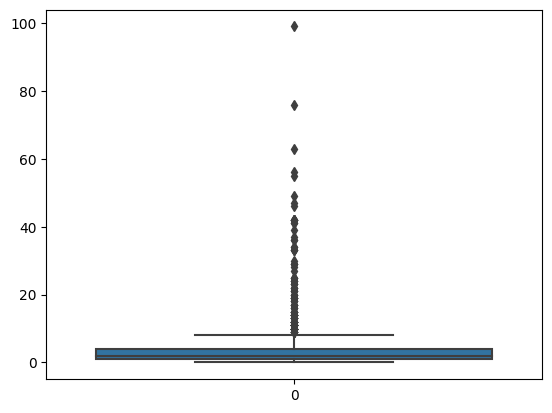

In [41]:
sns.boxplot(df.NumberofFloors)

In [43]:
df[df.NumberofFloors > 40 ].index

Index([2, 221, 222, 229, 231, 233, 256, 261, 271, 273, 292, 490, 559, 577,
       1359],
      dtype='int64')

Number of Buildings

In [11]:
df.NumberofBuildings.value_counts()

NumberofBuildings
1.0      1558
0.0        52
2.0        14
3.0        12
5.0         8
4.0         4
6.0         4
14.0        2
8.0         2
27.0        1
11.0        1
9.0         1
7.0         1
23.0        1
10.0        1
111.0       1
Name: count, dtype: int64

In [44]:
df[df.NumberofBuildings > 5].index

Index([ 105,  124,  128,  162,  167,  170,  364,  618, 1672, 1862, 1993, 2325,
       2901, 3168, 3274],
      dtype='int64')

PropertyGFA

{'whiskers': [<matplotlib.lines.Line2D at 0x206a12f2250>,
 'caps': [<matplotlib.lines.Line2D at 0x206a12af8d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x206a12f1310>],
 'medians': [<matplotlib.lines.Line2D at 0x206a13013d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x206a1301310>],
 'means': []}

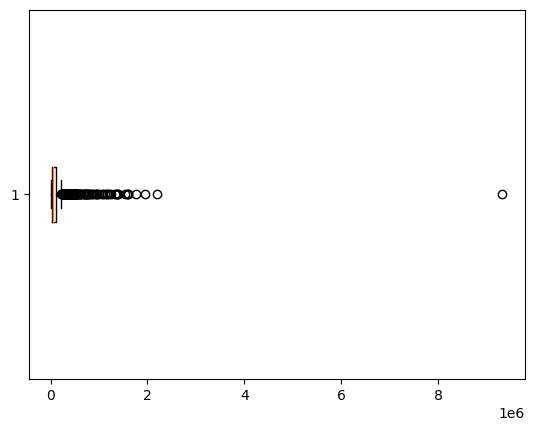

In [12]:
plt.boxplot(df.PropertyGFATotal, vert=False)

In [161]:
df[df.PropertyGFATotal > 1500000].sort_values(by='PropertyGFATotal')

,BuildingType,PrimaryPropertyType,PropertyName,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,...,Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity,is_laboratory,is_hospital,is_campus,decennie
273,NonResidential,Large Office,US Bank Centre,7,downtown,47.610540,-122.334660,1989,1.0,46,...,53668061.0,29380.699220,2938070.0,Compliant,530.18,0.35,0,0,0,8
155,NonResidential,Other,CenturyLink,2,greater duwamish,47.595440,-122.331590,1999,1.0,6,...,49439914.0,103175.179700,10317518.0,Compliant,892.63,0.56,0,0,0,9
490,NonResidential,Large Office,Russell Investments Center,7,downtown,47.607400,-122.337770,2005,1.0,42,...,55123924.0,3885.316895,388532.0,Compliant,481.06,0.30,0,0,0,10
292,NonResidential,Large Office,Two Union Square,7,downtown,47.610430,-122.332060,1989,1.0,56,...,46081813.0,25202.298830,2520230.0,Compliant,525.78,0.33,0,0,0,8
618,NonResidential,Hospital,Swedish First Hill,3,east,47.608951,-122.322402,1994,7.0,14,...,139354828.0,173161.203100,17316120.0,Compliant,12307.16,6.97,0,1,0,9
559,NonResidential,Large Office,Columbia Center - 2015,7,downtown,47.604540,-122.330720,1985,1.0,76,...,87851862.0,50857.632810,5085763.0,Compliant,882.56,0.45,0,0,0,8
1494,Campus,University,Entire Campus,3,east,47.610650,-122.317110,1939,1.0,2,...,61672821.0,529756.937500,52975694.0,Compliant,3243.48,1.47,0,0,1,3
3274,Campus,University,University of Washington - Seattle Campus,4,northeast,47.656440,-122.310410,1900,111.0,0,...,657074389.0,0.000000,0.0,Compliant,11140.56,1.20,0,0,1,0


PropertyGFAParking

In [14]:
df.PropertyGFAParking.value_counts()

PropertyGFAParking
0         1333
13320        3
10800        2
30000        2
25800        2
          ... 
115228       1
33921        1
44728        1
38400        1
85028        1
Name: count, Length: 326, dtype: int64

<Axes: >

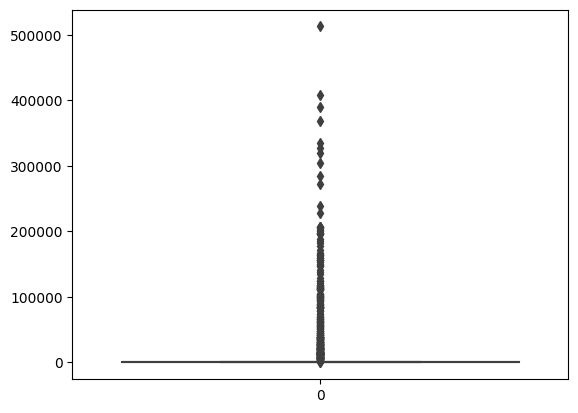

In [67]:
sns.boxplot(df['PropertyGFAParking'])

In [48]:
df[df.PropertyGFAParking >  200000 ].index

Index([  43,   77,  155,  163,  207,  212,  229,  271,  273,  292,  307,  338,
        492,  559,  577,  599, 2530, 3233],
      dtype='int64')

PropertyGFABuilding(s)

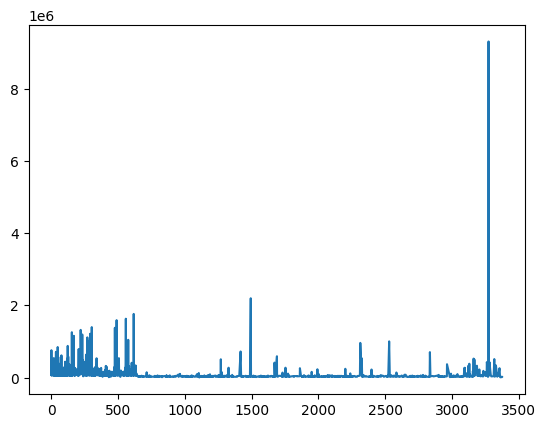

In [16]:
plt.plot(df['PropertyGFABuilding(s)'])

In [51]:
df[df['PropertyGFABuildings'] > 1500000].sort_values(by='PropertyGFABuildings', ascending=False).index

Index([3274, 1494, 618, 559, 490], dtype='int64')

ListOfAllPropertyUseTypes

In [17]:
df.ListOfAllPropertyUseTypes.unique().shape

(371,)

In [18]:
df.YearsENERGYSTARCertified.isnull().sum()

1567

EnergyStarScore

In [19]:
# soucis valeurs 590 valeurs nulles environ
df.ENERGYSTARScore.value_counts()

ENERGYSTARScore
100.0    40
89.0     27
98.0     27
95.0     26
96.0     24
         ..
24.0      3
7.0       3
13.0      3
39.0      3
9.0       3
Name: count, Length: 100, dtype: int64

SiteEUI(kBtu/sf)

<Axes: >

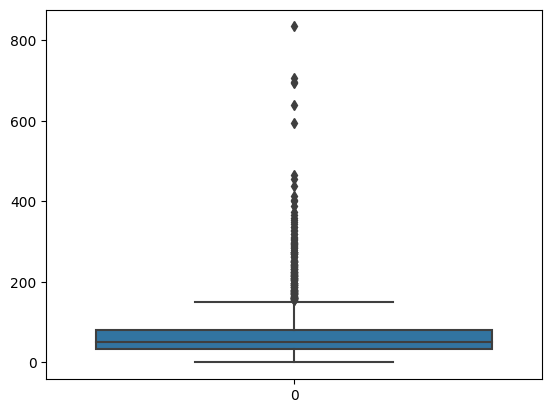

In [74]:
sns.boxplot(df['SiteEUI(kBtu/sf)'])

In [52]:
df[df['SiteEUI(kBtu/sf)'] > 500 ].sort_values(by='SiteEUI(kBtu/sf)', ascending=False).index

Index([240, 309, 809, 3203, 558, 3171], dtype='int64')

SiteEUIWN(kBtu/sf)

<Axes: >

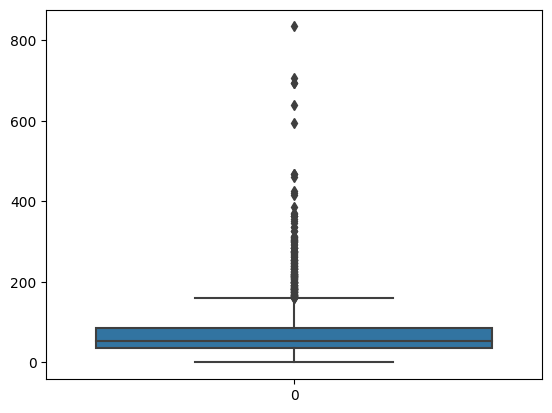

In [30]:
sns.boxplot(df['SiteEUIWN(kBtu/sf)'])

In [53]:
df[df['SiteEUIWN(kBtu/sf)'] > 500 ].sort_values(by='SiteEUIWN(kBtu/sf)', ascending=False).index

Index([240, 309, 3203, 809, 558, 3171], dtype='int64')

 'SiteEnergyUse(kBtu)', 

<Axes: >

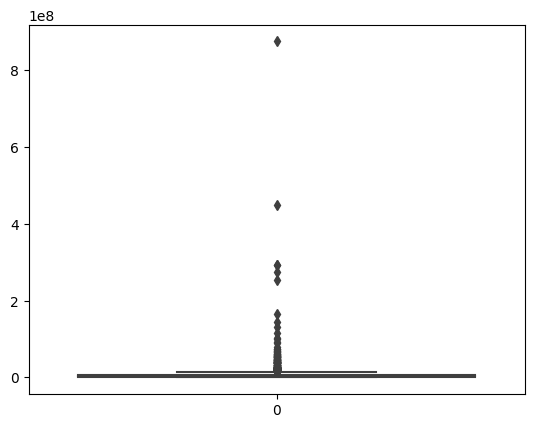

In [34]:
sns.boxplot(df['SiteEnergyUse(kBtu)'])

In [54]:
df[df['SiteEnergyUse(kBtu)'] > 200000000 ].sort_values(by='SiteEnergyUse(kBtu)', ascending=False).index

Index([3274, 35, 170, 618, 558, 124], dtype='int64')

'SteamUse(kBtu)'

<Axes: >

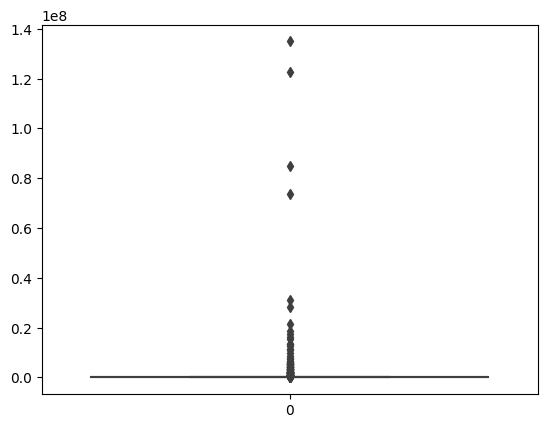

In [35]:
sns.boxplot(df['SteamUse(kBtu)'])

In [56]:
df[df['SteamUse(kBtu)'] > 20000000 ].sort_values(by='SteamUse(kBtu)', ascending=False).index

Index([618, 170, 3274, 3264, 3156, 262, 2], dtype='int64')

In [36]:
df[df['SteamUse(kBtu)'] == 0].shape

(1549, 46)

Electricity(kWh)

<Axes: >

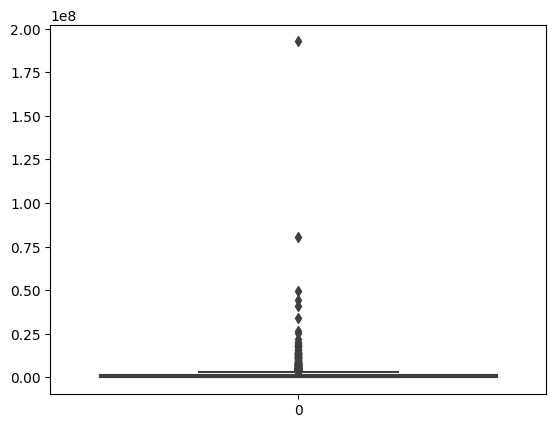

In [38]:
sns.boxplot(df["Electricity(kWh)"])

In [57]:
df[df['Electricity(kWh)'] > 25000000 ].sort_values(by='Electricity(kWh)', ascending=False).index

Index([3274, 558, 170, 35, 618, 124, 3264, 559], dtype='int64')

Natural Gas (therms and kBtu)

<Axes: >

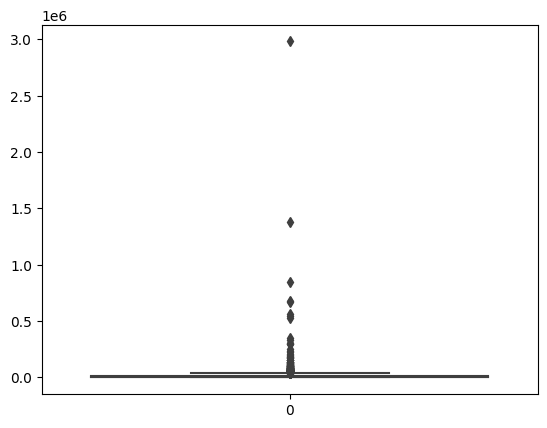

In [47]:
sns.boxplot(df['NaturalGas(therms)'])

In [58]:
df[df['NaturalGas(therms)'] > 500000 ].sort_values(by='NaturalGas(therms)', ascending=False).index

Index([35, 124, 167, 2325, 340, 1672, 1690, 1494], dtype='int64')

Default Data 

In [49]:
df['DefaultData'].value_counts()

DefaultData
False    1577
True       88
Name: count, dtype: int64

<Axes: xlabel='DefaultData', ylabel='TotalGHGEmissions'>

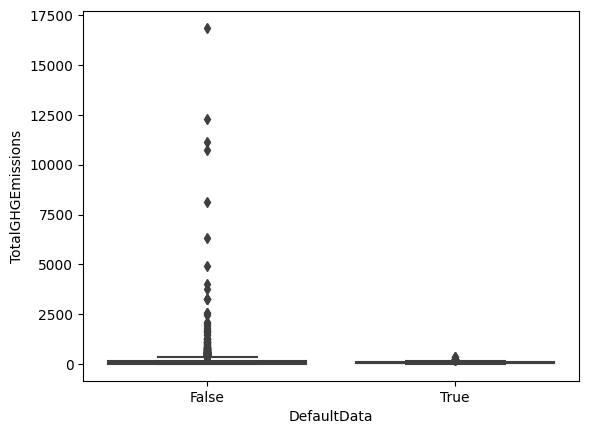

In [85]:
sns.boxplot(x= df['DefaultData'],y=df['TotalGHGEmissions'])

Comments

In [52]:
df['Comments'].isnull().sum()

1665

ComplianceStatus

In [54]:
df.ComplianceStatus.value_counts()

ComplianceStatus
Compliant                       1546
Error - Correct Default Data      88
Non-Compliant                     17
Missing Data                      14
Name: count, dtype: int64

Outlier

In [55]:
df.Outlier.value_counts()

Outlier
Low outlier     14
High outlier     2
Name: count, dtype: int64

TotalGHGEmissions & GHGEmissionsIntensity

<Axes: >

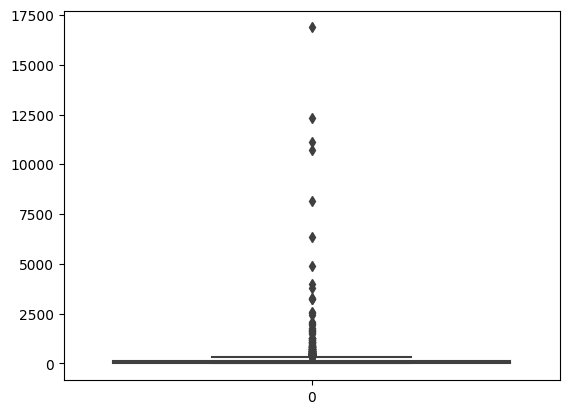

In [56]:
sns.boxplot(df['TotalGHGEmissions'])

In [59]:
df[df['TotalGHGEmissions'] > 5000 ].sort_values(by='TotalGHGEmissions', ascending=False).index

Index([35, 618, 3274, 170, 124, 3264], dtype='int64')

<Axes: >

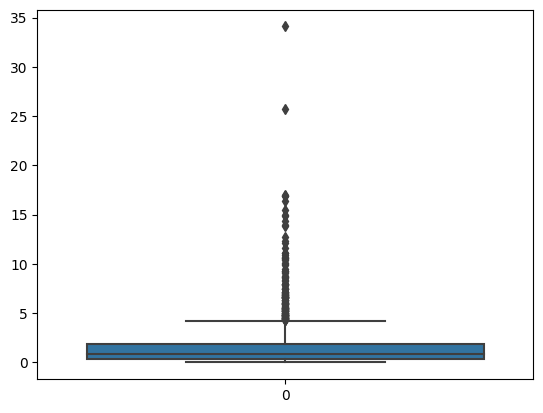

In [57]:
sns.boxplot(df['GHGEmissionsIntensity'])

In [62]:
df[df['GHGEmissionsIntensity'] > 14 ].sort_values(by='GHGEmissionsIntensity', ascending=False).index

Index([35, 809, 3373, 3365, 3264, 1817, 1279, 1753, 2380, 3156], dtype='int64')

In [ ]:
outliers index :
Hopitaux : 
Campus : 

<Axes: >

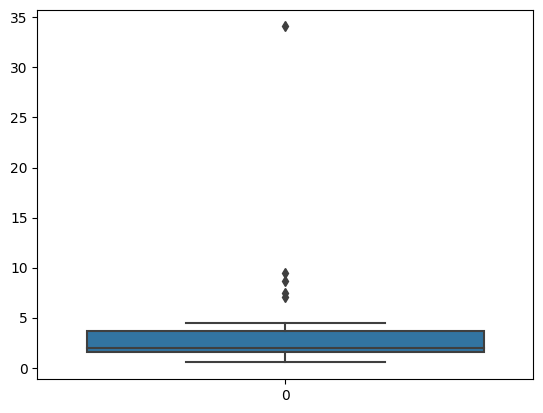

In [67]:
sns.boxplot(df[df.BuildingType.isin(['Campus','Hospital'])]['GHGEmissionsIntensity'].values)

In [85]:
df.PrimaryPropertyType.unique()

array(['Hotel', 'Other', 'Mixed Use Property', 'K-12 School',
       'University', 'Small- and Mid-Sized Office',
       'Self-Storage Facility', 'Warehouse', 'Large Office',
       'Senior Care Community', 'Medical Office', 'Retail Store',
       'Hospital', 'Distribution Center', 'Worship Facility',
       'Supermarket / Grocery Store', 'Laboratory',
       'Refrigerated Warehouse', 'Restaurant', 'Office'], dtype=object)

In [86]:
df[df.BuildingType.isin(['K-12 School'])]['GHGEmissionsIntensity'].mean()

nan

In [73]:
df[df.BuildingType.isin(['Campus'])]['GHGEmissionsIntensity'].mean()

4.325652173913043

In [93]:
df.loc[df.PrimaryPropertyType.isin(['Mixed Use Property'])].sort_values(by='GHGEmissionsIntensity', ascending = False)

,BuildingType,PrimaryPropertyType,PropertyName,Address,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,...,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
35,Campus,Mixed Use Property,Plant 2 Site,7755 E MARGINAL WAY S,2,GREATER DUWAMISH,47.53493,-122.31788,1992,1.0,...,4.483853e+08,4.716139e+08,0.0,4.410208e+07,150476283.0,2.979090e+06,297909000.0,Compliant,16870.98,34.09
2380,NonResidential,Mixed Use Property,Chandler's Cove - SEDO,901 Fairview Ave. N.,3,LAKE UNION,47.62774,-122.33384,1988,1.0,...,1.548068e+07,1.596084e+07,0.0,1.946760e+06,6642344.0,8.838336e+04,8838336.0,Compliant,515.71,14.89
47,NonResidential,Mixed Use Property,Mann Building,1401 3rd Avenue,7,DOWNTOWN,47.60886,-122.33744,1926,1.0,...,1.502620e+07,1.568374e+07,0.0,1.357696e+06,4632459.0,1.039374e+05,10393737.0,Compliant,584.31,11.12
373,NonResidential,Mixed Use Property,Seattle Art Museum,1300 1st Avenue,7,DOWNTOWN,47.60740,-122.33777,1991,1.0,...,5.296080e+07,5.373420e+07,17548416.0,1.023939e+07,34936812.0,4.755600e+03,475560.0,Compliant,1623.34,10.50
986,NonResidential,Mixed Use Property,Matador/Jak's Grill/8 Limbs Yoga/Fitness,4546 California Ave SW,1,SOUTHWEST,47.56147,-122.38638,1930,1.0,...,4.265815e+06,4.345884e+06,0.0,2.406832e+05,821211.0,3.444604e+04,3444604.0,Compliant,188.67,9.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1839,NonResidential,Mixed Use Property,The Travelers Hotel,80 Yesler Way,7,DOWNTOWN,47.60195,-122.33516,1913,1.0,...,7.697713e+05,7.697713e+05,0.0,2.256070e+05,769771.0,0.000000e+00,0.0,Compliant,5.37,0.12
796,NonResidential,Mixed Use Property,U.S. BANK,2401 3RD AVE,7,DOWNTOWN,47.61543,-122.34651,1954,1.0,...,4.183485e+05,4.507802e+05,0.0,1.226109e+05,418348.0,0.000000e+00,0.0,Compliant,2.92,0.10
3041,NonResidential,Mixed Use Property,1700 Madison Apts. Bldg. 2,1700 E Madison St,3,Central,47.61608,-122.30967,2004,1.0,...,1.021755e+06,1.056508e+06,0.0,2.994591e+05,1021754.0,0.000000e+00,0.0,Compliant,7.12,0.07
2182,NonResidential,Mixed Use Property,JukeboxCity Building,1946-1952 1st Ave S,2,GREATER DUWAMISH,47.58452,-122.33370,1916,1.0,...,2.298564e+05,2.483349e+05,0.0,6.736710e+04,229857.0,0.000000e+00,0.0,Compliant,1.60,0.06


In [71]:
df['GHGEmissionsIntensity'].std()

2.350095480155586

## Analyse Bivariée

In [125]:
def boxplot_test(col,target, violin = False):
  print(f"\n Distribution de {target} et  {col}")
  freq_col = pd.DataFrame(df[[target,col]])
  freq_col[col] = freq_col[col].astype('str')
  print(df[col].value_counts())
  sns.color_palette("Set2")
  if violin :
    sns.violinplot(x=freq_col[target],y=freq_col[col], palette="pastel")
  else :
    sns.boxplot(x=freq_col[target],y=freq_col[col], palette="Set2",showfliers=False)
  plt.title(col)
  plt.show()

In [126]:
def scatter_test(col,target):
    sns.color_palette("Set2")
    freq_col = pd.DataFrame(df[[target,col]])
    sns.scatterplot(y=freq_col[target],x=freq_col[col])
    plt.title(col)
    plt.show()

In [115]:
# 'Latitude', 'Longitude', 
cols_num = [
       'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)','SteamUse(kBtu)','Electricity(kBtu)',
       'NaturalGas(kBtu)','PropertyGFATotal', 'PropertyGFAParking','PropertyGFABuildings']
cols_categ = ['Neighborhood','BuildingType', 'PrimaryPropertyType','YearBuilt', 'NumberofBuildings',
       'NumberofFloors','decennie','LargestPropertyUseType']

ord_categ = ['NumberofBuildings','NumberofFloors','decennie','YearBuilt']

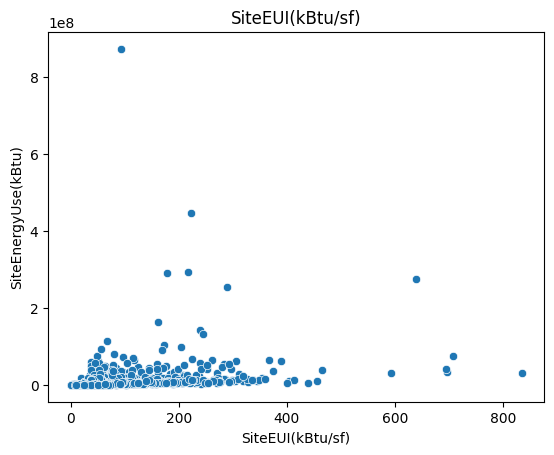

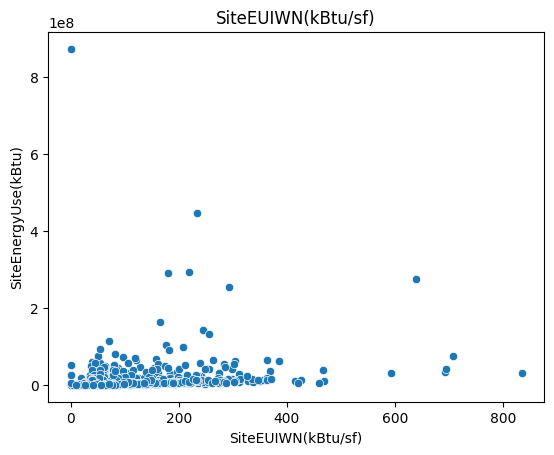

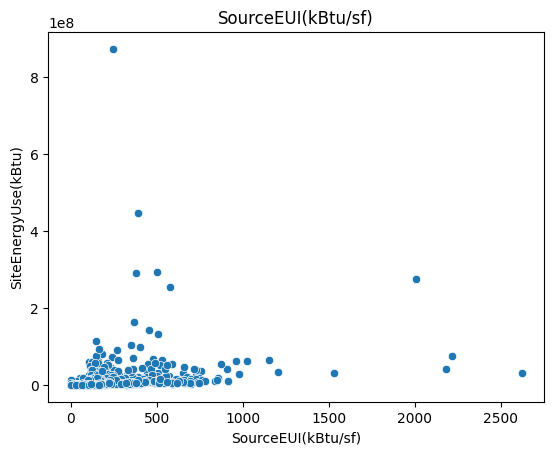

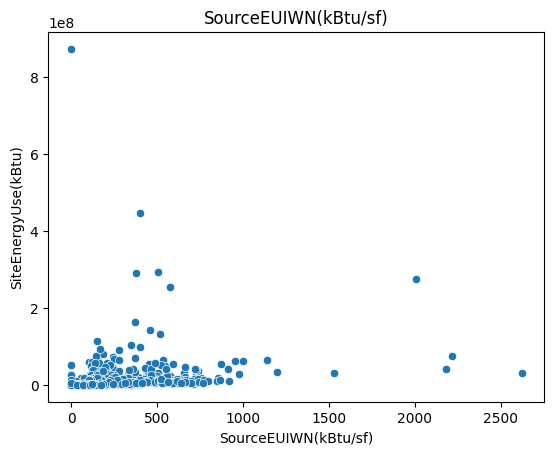

ValueError: If using all scalar values, you must pass an index

In [151]:
for col_num in cols_num : 
    scatter_test(col_num,'SiteEnergyUse(kBtu)')

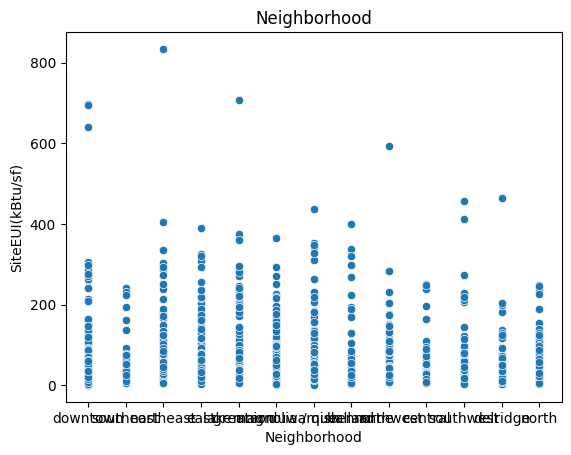

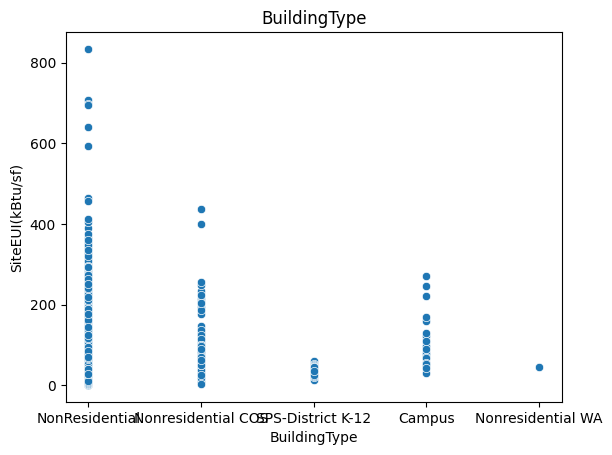

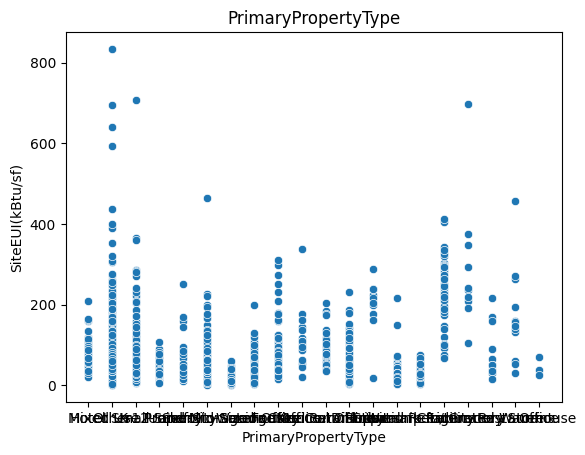

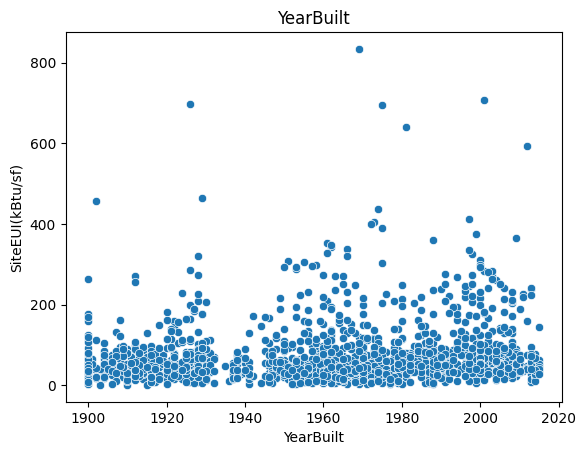

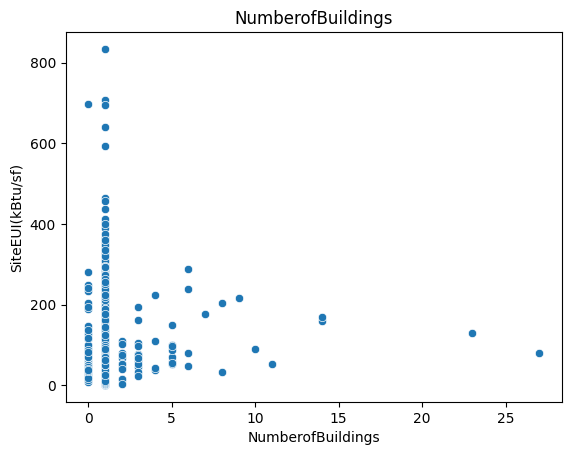

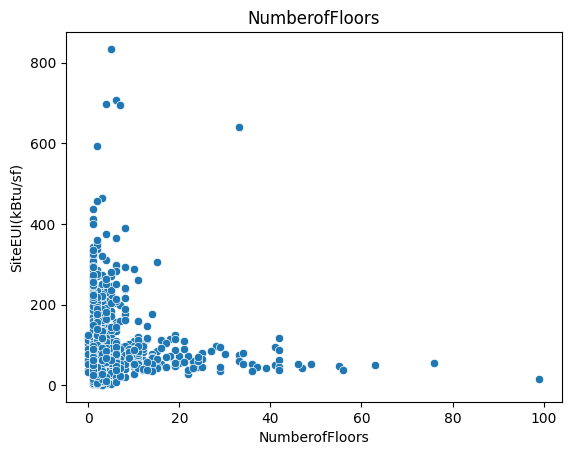

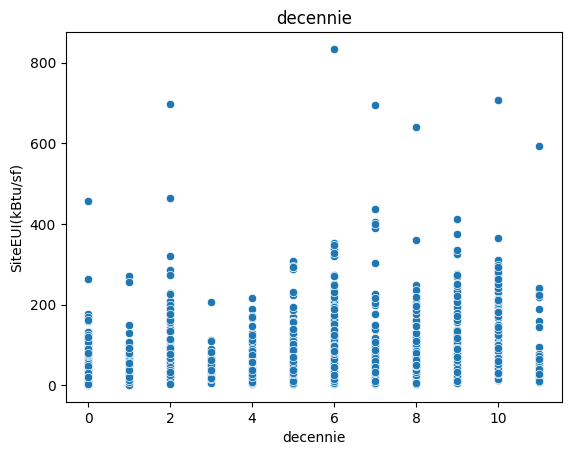

In [242]:
for col_categ in cols_categ : 
    scatter_test(col_categ,'SiteEUI(kBtu/sf)')


 Distribution de TotalGHGEmissions et  Neighborhood
Neighborhood
downtown                 356
greater duwamish         345
magnolia / queen anne    147
lake union               145
east                     118
northeast                112
northwest                 85
ballard                   68
north                     64
central                   52
delridge                  46
southeast                 45
southwest                 40
Name: count, dtype: int64


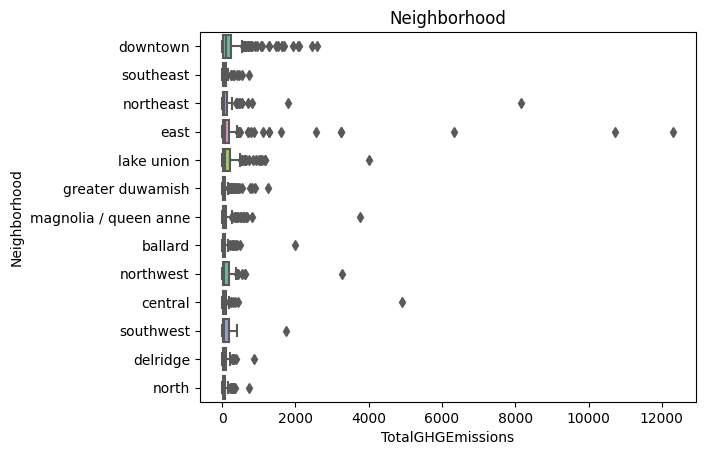


 Distribution de TotalGHGEmissions et  BuildingType
BuildingType
NonResidential        1433
Nonresidential COS      85
SPS-District K-12       83
Campus                  21
Nonresidential WA        1
Name: count, dtype: int64


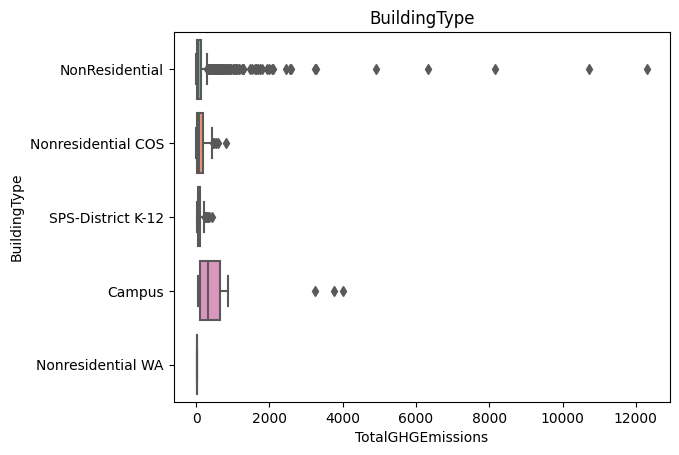


 Distribution de TotalGHGEmissions et  PrimaryPropertyType
PrimaryPropertyType
Small- and Mid-Sized Office    291
Other                          248
Warehouse                      187
Large Office                   173
K-12 School                    124
Mixed Use Property             112
Retail Store                    91
Hotel                           76
Worship Facility                71
Distribution Center             53
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           28
University                      23
Senior Care Community           20
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Office                           3
Name: count, dtype: int64


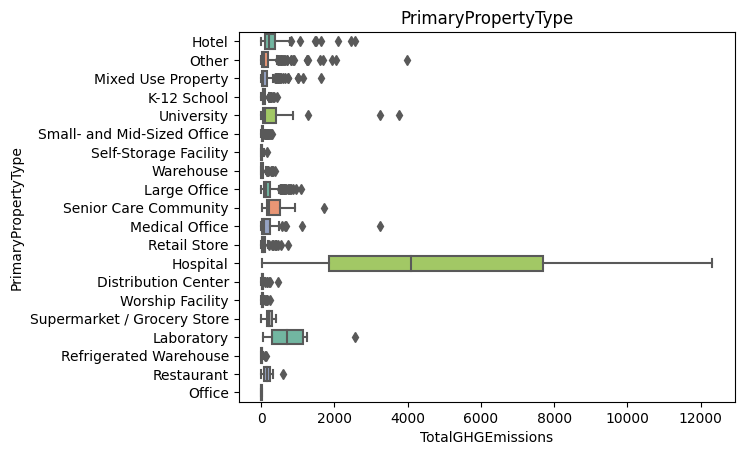


 Distribution de TotalGHGEmissions et  YearBuilt
YearBuilt
1900    45
2000    34
1970    32
1910    30
1960    30
        ..
1939     2
1901     2
1942     2
1936     1
1935     1
Name: count, Length: 113, dtype: int64


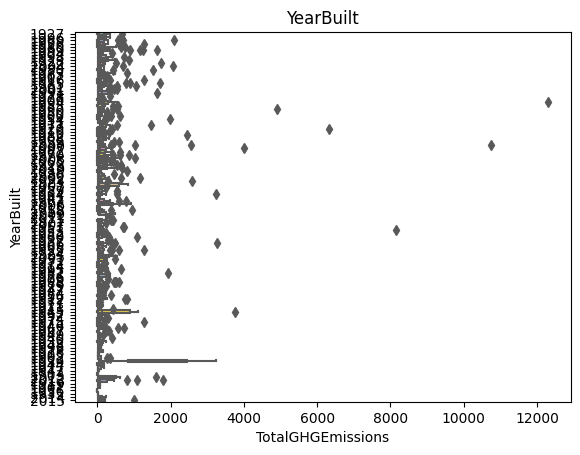


 Distribution de TotalGHGEmissions et  NumberofBuildings
NumberofBuildings
1.0     1520
0.0       51
2.0       14
3.0       12
5.0        8
4.0        4
6.0        4
14.0       2
8.0        2
27.0       1
11.0       1
9.0        1
7.0        1
23.0       1
10.0       1
Name: count, dtype: int64


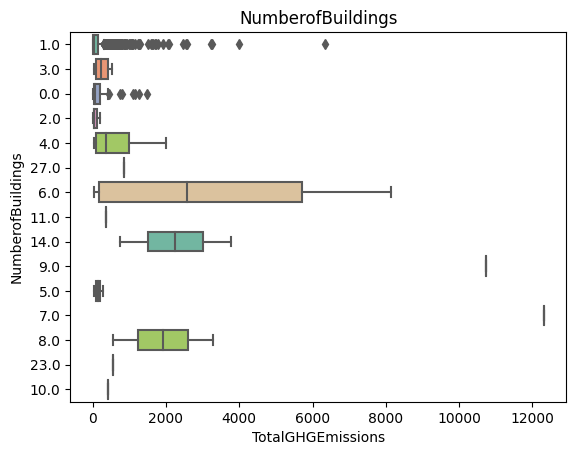


 Distribution de TotalGHGEmissions et  NumberofFloors
NumberofFloors
1     457
2     385
3     255
4     140
5     101
6      83
7      33
8      22
10     18
11     18
0      11
14      9
12      9
9       7
13      7
42      5
19      5
15      5
17      4
16      3
21      3
22      3
23      3
29      3
18      3
20      3
24      3
25      3
33      3
36      2
34      2
41      2
46      1
99      1
27      1
76      1
56      1
30      1
28      1
55      1
63      1
37      1
49      1
47      1
39      1
Name: count, dtype: int64


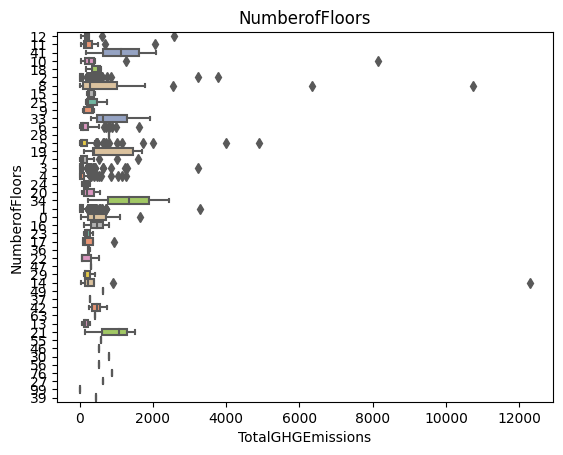


 Distribution de TotalGHGEmissions et  decennie
decennie
6     225
10    198
8     166
2     165
7     163
5     162
9     145
0     121
1     110
4      62
3      53
11     53
Name: count, dtype: int64


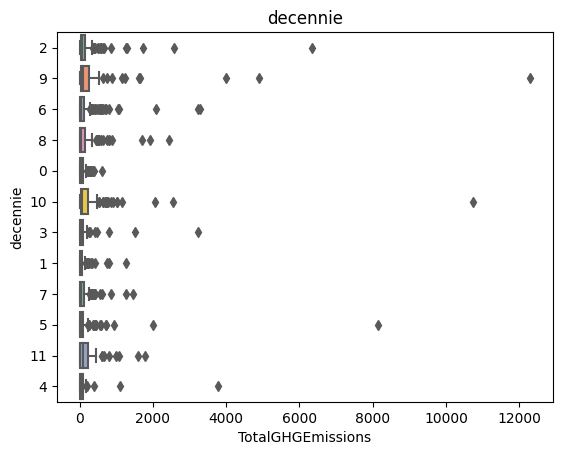


 Distribution de TotalGHGEmissions et  LargestPropertyUseType
LargestPropertyUseType
Office                                                  497
Non-Refrigerated Warehouse                              199
K-12 School                                             124
Retail Store                                             99
Other                                                    98
Hotel                                                    77
Worship Facility                                         71
Distribution Center                                      54
Supermarket/Grocery Store                                41
Medical Office                                           41
Other - Recreation                                       31
Parking                                                  30
Self-Storage Facility                                    28
College/University                                       23
Other - Entertainment/Public Assembly                    21
Senior Care Co

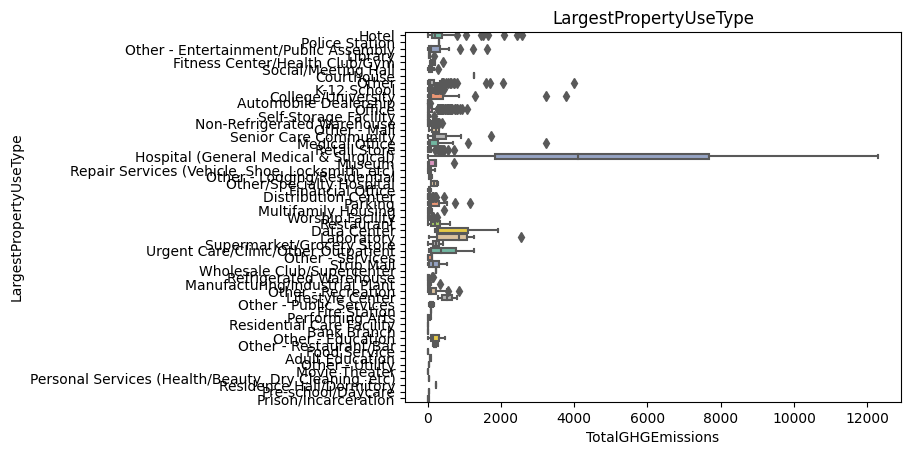

In [118]:
for col_categ in cols_categ : 
    boxplot_test(col_categ,'TotalGHGEmissions')

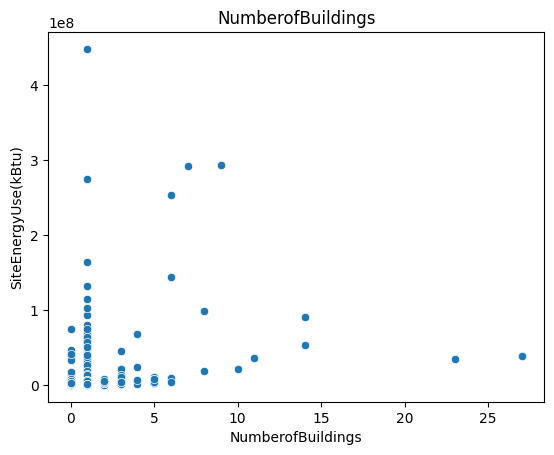

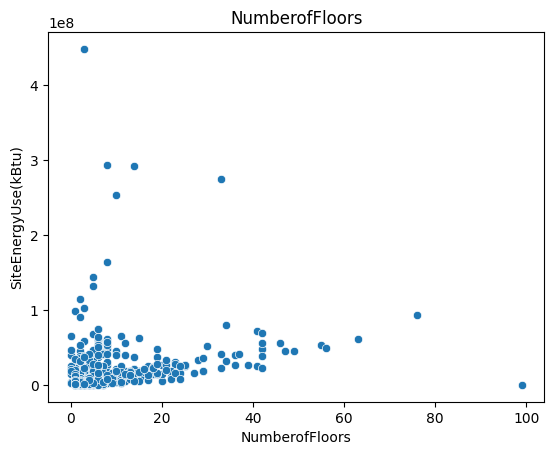

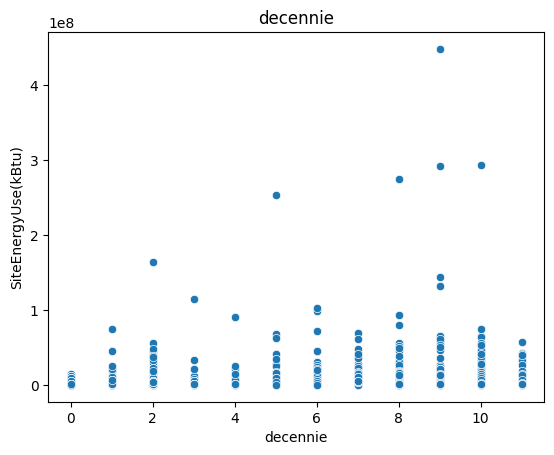

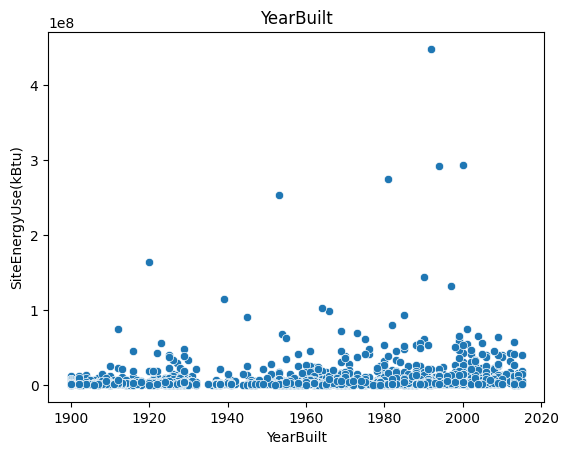

In [255]:
for col_ord in ord_categ : 
    scatter_test(col_ord,'SiteEnergyUse(kBtu)')

In [150]:
df = pd.get_dummies(df,columns=['LargestPropertyUseType'])
df.columns

Index(['BuildingType', 'PrimaryPropertyType', 'PropertyName',
       'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude',
       'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuildings',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseTypeGFA',
       'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)',
       'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)',
       'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)',
       'NaturalGas(therms)', 'NaturalGas(kBtu)', 'ComplianceStatus',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'is_laboratory',
       'is_campus', 'is_hospital', 'decennie', 'p_gas', 'p_elec', 'p_steam',
       'LargestPropertyUseType_Adult Education',
       'LargestPropertyUseType_Automobile Dealership',
       'LargestPropertyUseType_Bank Branch',
       'LargestPropertyUseType_College/University',
       'LargestPropertyUseType_Courth

In [123]:
larg_columns = ['LargestPropertyUseType_Adult Education',
       'LargestPropertyUseType_Automobile Dealership',
       'LargestPropertyUseType_Bank Branch',
       'LargestPropertyUseType_College/University',
       'LargestPropertyUseType_Courthouse',
       'LargestPropertyUseType_Data Center',
       'LargestPropertyUseType_Distribution Center',
       'LargestPropertyUseType_Financial Office',
       'LargestPropertyUseType_Fire Station',
       'LargestPropertyUseType_Fitness Center/Health Club/Gym',
       'LargestPropertyUseType_Food Service',
       'LargestPropertyUseType_Hospital (General Medical & Surgical)',
       'LargestPropertyUseType_Hotel', 'LargestPropertyUseType_K-12 School',
       'LargestPropertyUseType_Laboratory', 'LargestPropertyUseType_Library',
       'LargestPropertyUseType_Lifestyle Center',
       'LargestPropertyUseType_Manufacturing/Industrial Plant',
       'LargestPropertyUseType_Medical Office',
       'LargestPropertyUseType_Movie Theater',
       'LargestPropertyUseType_Multifamily Housing',
       'LargestPropertyUseType_Museum',
       'LargestPropertyUseType_Non-Refrigerated Warehouse',
       'LargestPropertyUseType_Office', 'LargestPropertyUseType_Other',
       'LargestPropertyUseType_Other - Education',
       'LargestPropertyUseType_Other - Entertainment/Public Assembly',
       'LargestPropertyUseType_Other - Lodging/Residential',
       'LargestPropertyUseType_Other - Mall',
       'LargestPropertyUseType_Other - Public Services',
       'LargestPropertyUseType_Other - Recreation',
       'LargestPropertyUseType_Other - Restaurant/Bar',
       'LargestPropertyUseType_Other - Services',
       'LargestPropertyUseType_Other - Utility',
       'LargestPropertyUseType_Other/Specialty Hospital',
       'LargestPropertyUseType_Parking',
       'LargestPropertyUseType_Performing Arts',
       'LargestPropertyUseType_Personal Services (Health/Beauty, Dry Cleaning, etc)',
       'LargestPropertyUseType_Police Station',
       'LargestPropertyUseType_Pre-school/Daycare',
       'LargestPropertyUseType_Prison/Incarceration',
       'LargestPropertyUseType_Refrigerated Warehouse',
       'LargestPropertyUseType_Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'LargestPropertyUseType_Residence Hall/Dormitory',
       'LargestPropertyUseType_Residential Care Facility',
       'LargestPropertyUseType_Restaurant',
       'LargestPropertyUseType_Retail Store',
       'LargestPropertyUseType_Self-Storage Facility',
       'LargestPropertyUseType_Senior Care Community',
       'LargestPropertyUseType_Social/Meeting Hall',
       'LargestPropertyUseType_Strip Mall',
       'LargestPropertyUseType_Supermarket/Grocery Store',
       'LargestPropertyUseType_Urgent Care/Clinic/Other Outpatient',
       'LargestPropertyUseType_Wholesale Club/Supercenter',
       'LargestPropertyUseType_Worship Facility']


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Adult Education
LargestPropertyUseType_Adult Education
False    1621
True        2
Name: count, dtype: int64


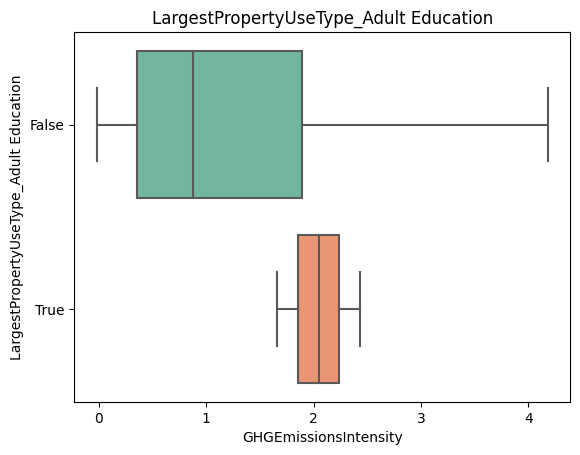


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Automobile Dealership
LargestPropertyUseType_Automobile Dealership
False    1618
True        5
Name: count, dtype: int64


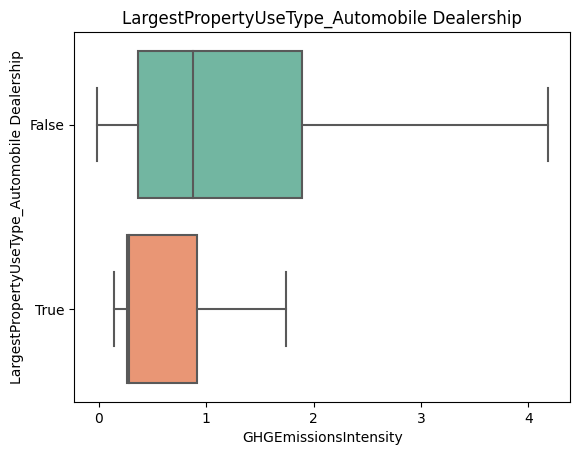


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Bank Branch
LargestPropertyUseType_Bank Branch
False    1619
True        4
Name: count, dtype: int64


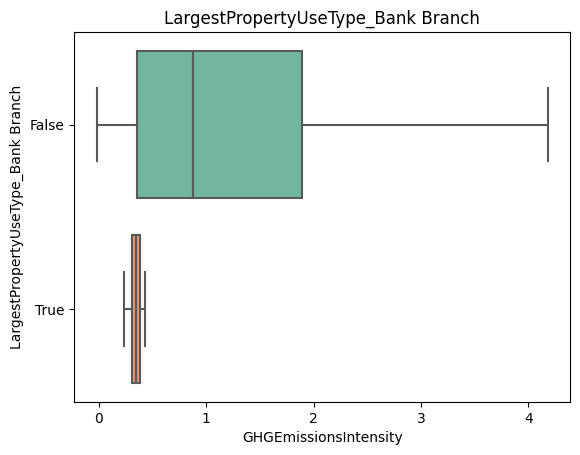


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_College/University
LargestPropertyUseType_College/University
False    1600
True       23
Name: count, dtype: int64


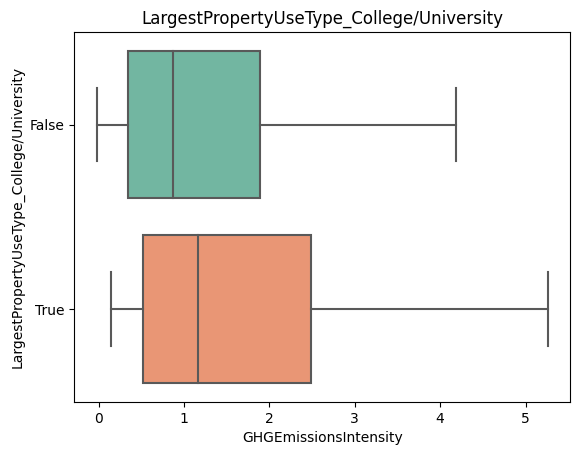


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Courthouse
LargestPropertyUseType_Courthouse
False    1622
True        1
Name: count, dtype: int64


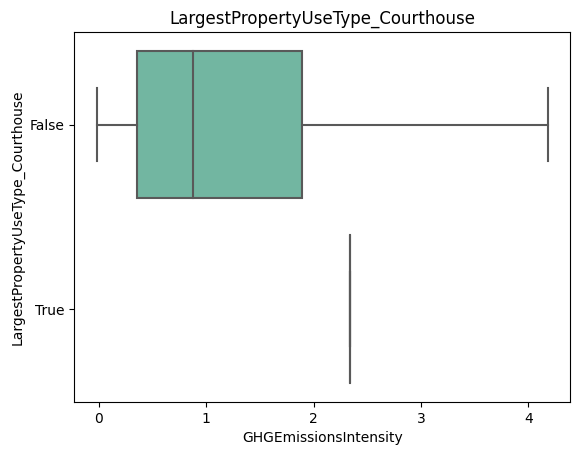


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Data Center
LargestPropertyUseType_Data Center
False    1620
True        3
Name: count, dtype: int64


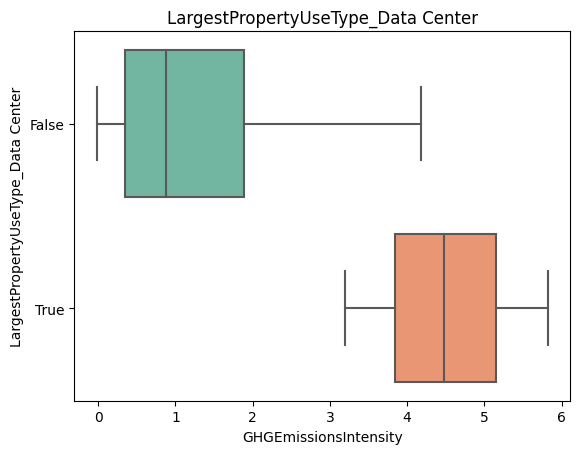


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Distribution Center
LargestPropertyUseType_Distribution Center
False    1569
True       54
Name: count, dtype: int64


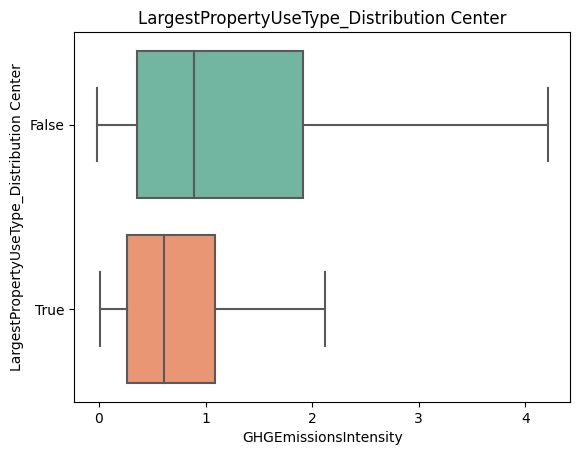


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Financial Office
LargestPropertyUseType_Financial Office
False    1619
True        4
Name: count, dtype: int64


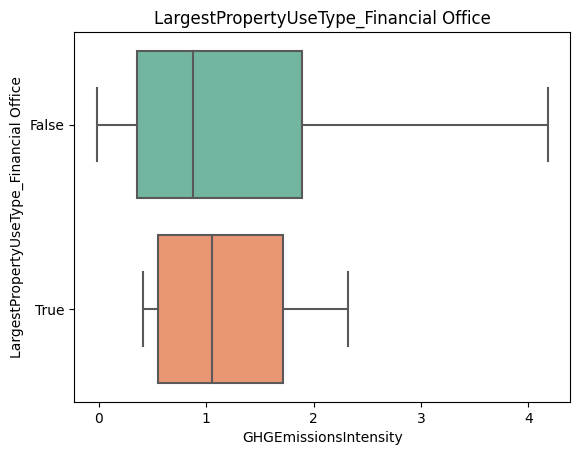


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Fire Station
LargestPropertyUseType_Fire Station
False    1622
True        1
Name: count, dtype: int64


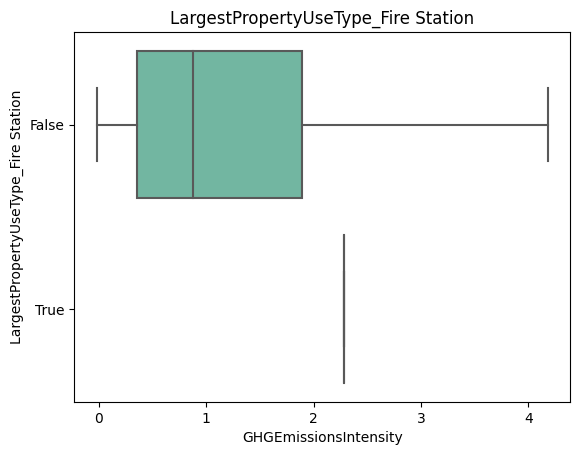


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Fitness Center/Health Club/Gym
LargestPropertyUseType_Fitness Center/Health Club/Gym
False    1618
True        5
Name: count, dtype: int64


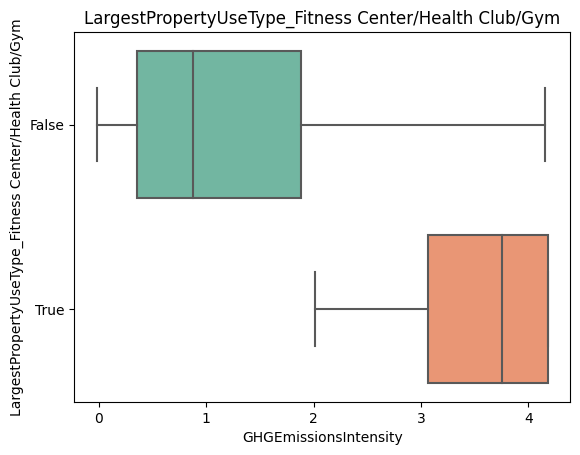


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Food Service
LargestPropertyUseType_Food Service
False    1622
True        1
Name: count, dtype: int64


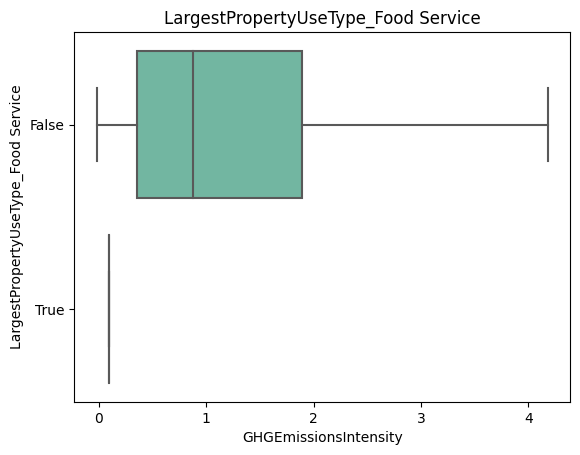


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Hospital (General Medical & Surgical)
LargestPropertyUseType_Hospital (General Medical & Surgical)
False    1613
True       10
Name: count, dtype: int64


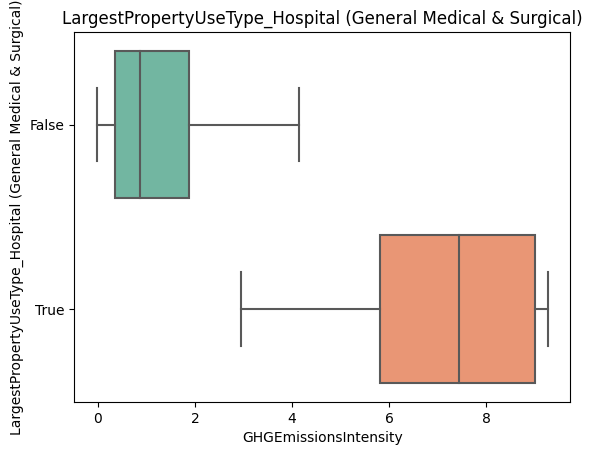


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Hotel
LargestPropertyUseType_Hotel
False    1546
True       77
Name: count, dtype: int64


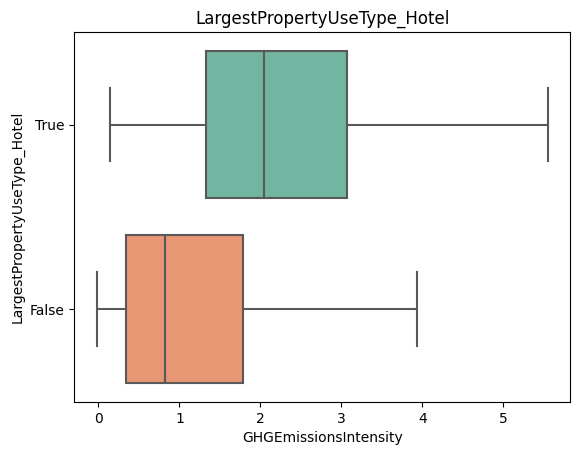


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_K-12 School
LargestPropertyUseType_K-12 School
False    1499
True      124
Name: count, dtype: int64


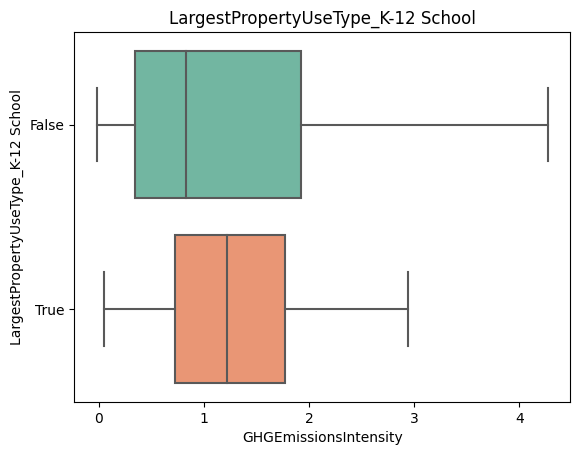


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Laboratory
LargestPropertyUseType_Laboratory
False    1610
True       13
Name: count, dtype: int64


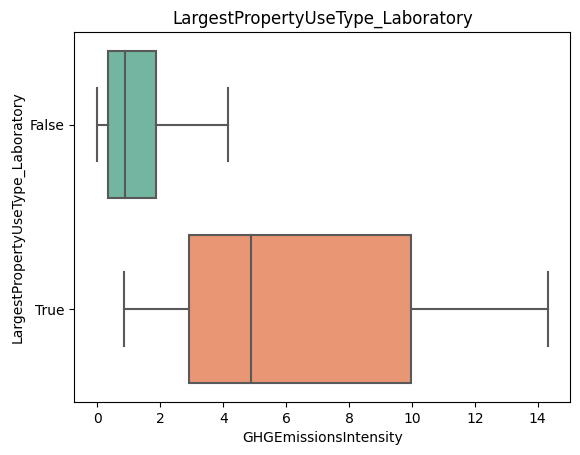


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Library
LargestPropertyUseType_Library
False    1619
True        4
Name: count, dtype: int64


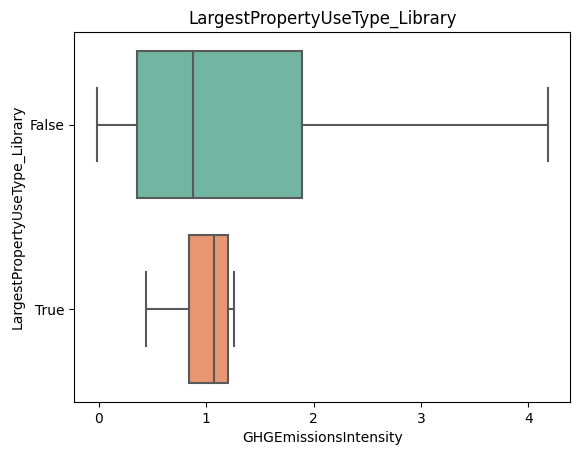


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Lifestyle Center
LargestPropertyUseType_Lifestyle Center
False    1621
True        2
Name: count, dtype: int64


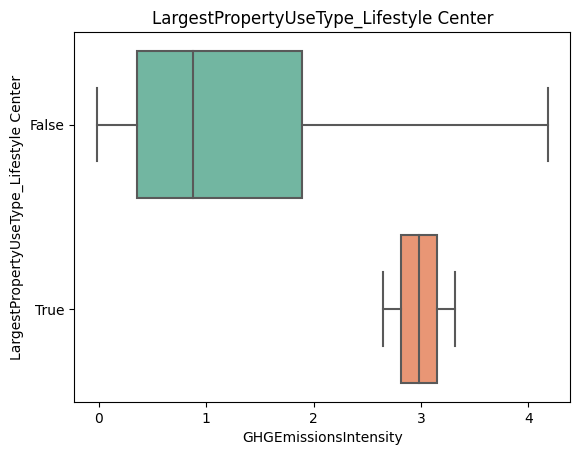


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Manufacturing/Industrial Plant
LargestPropertyUseType_Manufacturing/Industrial Plant
False    1615
True        8
Name: count, dtype: int64


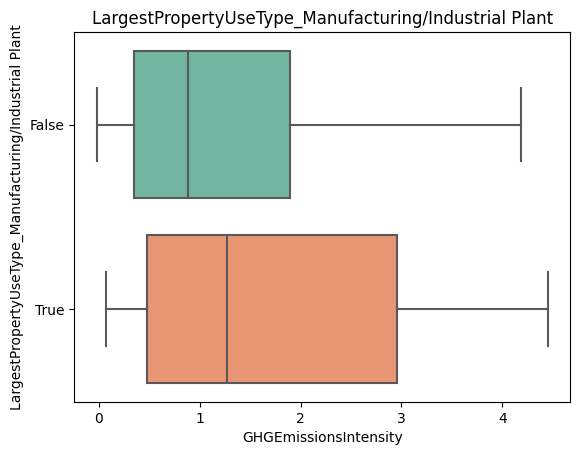


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Medical Office
LargestPropertyUseType_Medical Office
False    1582
True       41
Name: count, dtype: int64


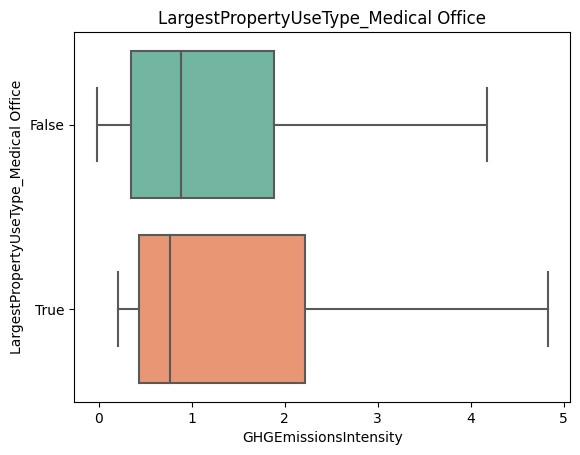


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Movie Theater
LargestPropertyUseType_Movie Theater
False    1622
True        1
Name: count, dtype: int64


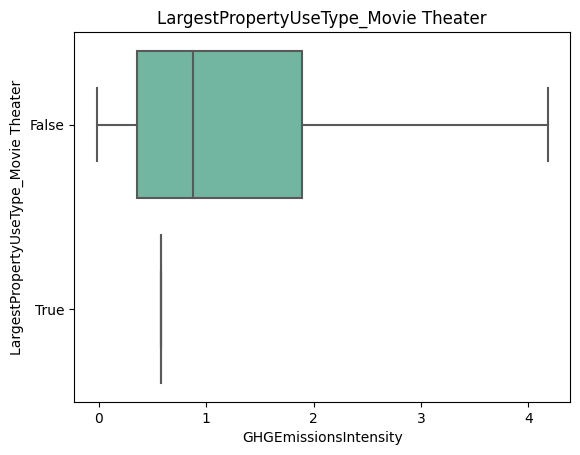


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Multifamily Housing
LargestPropertyUseType_Multifamily Housing
False    1614
True        9
Name: count, dtype: int64


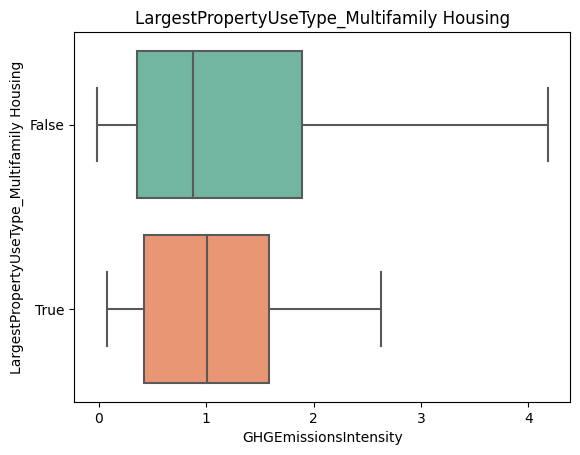


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Museum
LargestPropertyUseType_Museum
False    1618
True        5
Name: count, dtype: int64


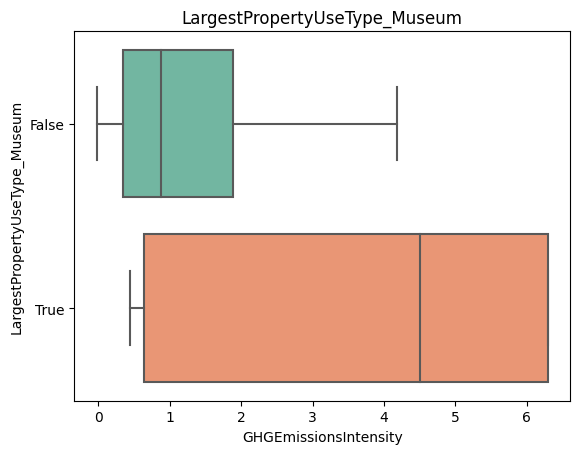


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Non-Refrigerated Warehouse
LargestPropertyUseType_Non-Refrigerated Warehouse
False    1424
True      199
Name: count, dtype: int64


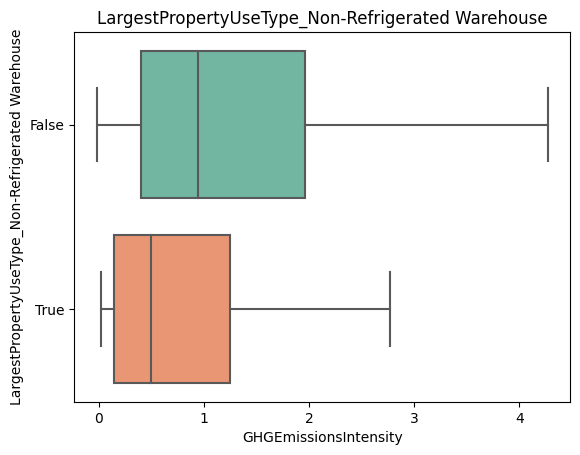


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Office
LargestPropertyUseType_Office
False    1126
True      497
Name: count, dtype: int64


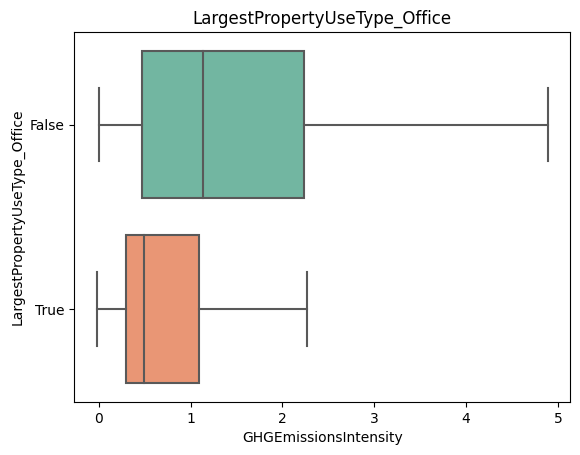


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Other
LargestPropertyUseType_Other
False    1525
True       98
Name: count, dtype: int64


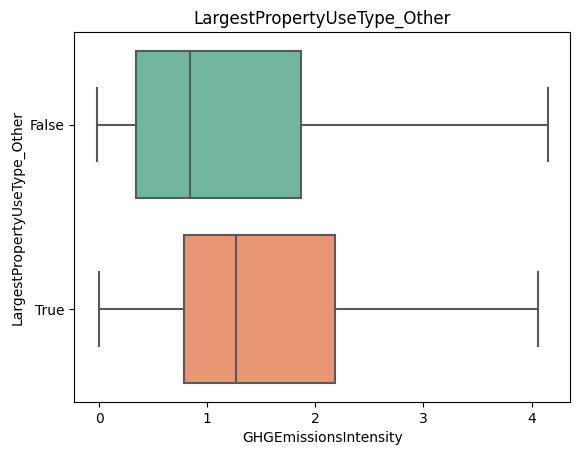


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Other - Education
LargestPropertyUseType_Other - Education
False    1620
True        3
Name: count, dtype: int64


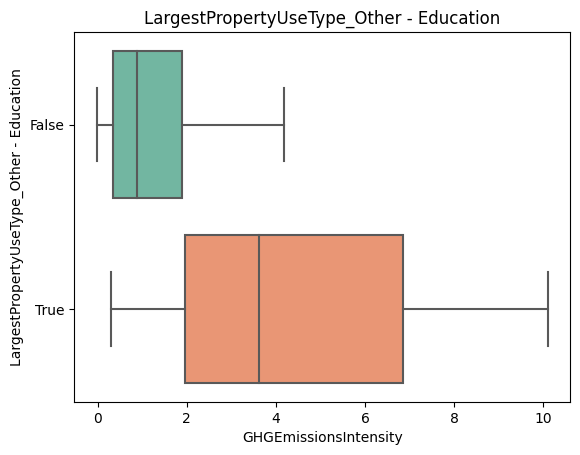


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Other - Entertainment/Public Assembly
LargestPropertyUseType_Other - Entertainment/Public Assembly
False    1602
True       21
Name: count, dtype: int64


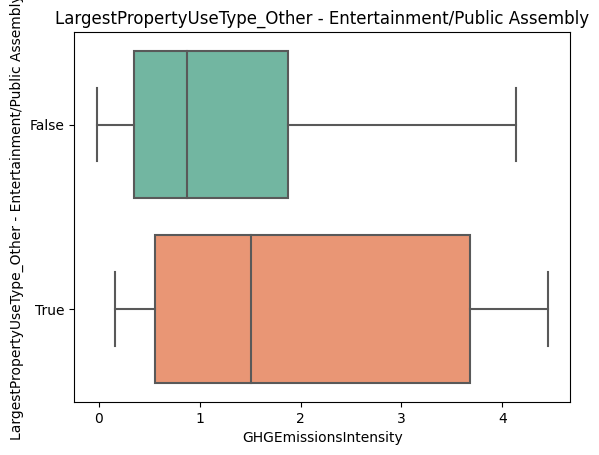


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Other - Lodging/Residential
LargestPropertyUseType_Other - Lodging/Residential
False    1618
True        5
Name: count, dtype: int64


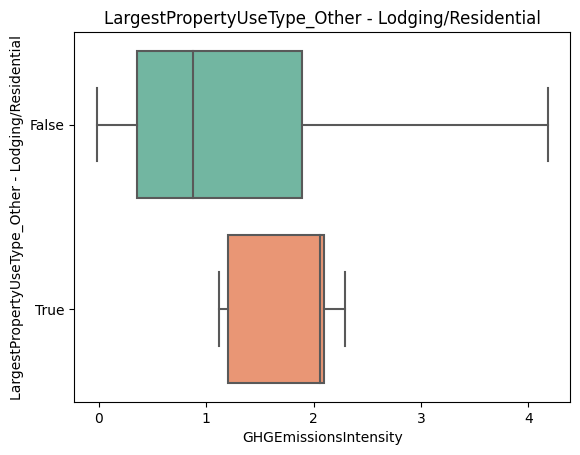


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Other - Mall
LargestPropertyUseType_Other - Mall
False    1619
True        4
Name: count, dtype: int64


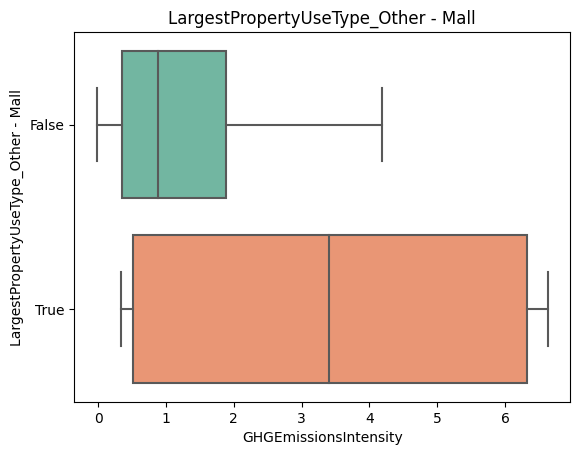


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Other - Public Services
LargestPropertyUseType_Other - Public Services
False    1621
True        2
Name: count, dtype: int64


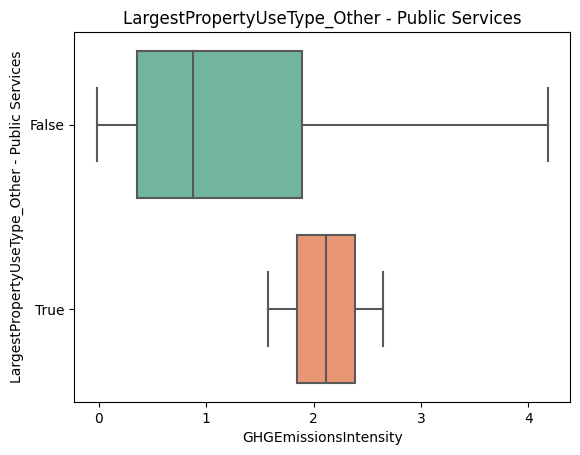


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Other - Recreation
LargestPropertyUseType_Other - Recreation
False    1592
True       31
Name: count, dtype: int64


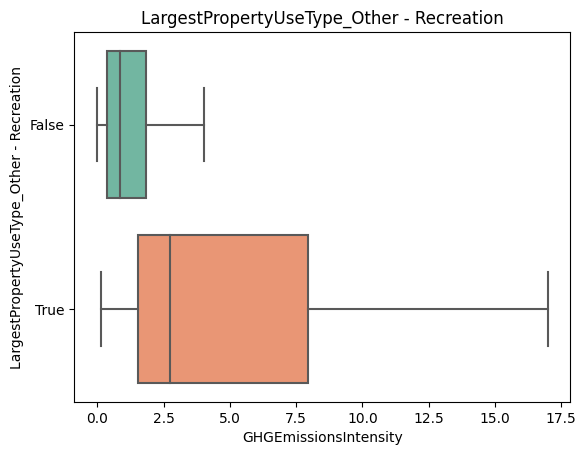


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Other - Restaurant/Bar
LargestPropertyUseType_Other - Restaurant/Bar
False    1621
True        2
Name: count, dtype: int64


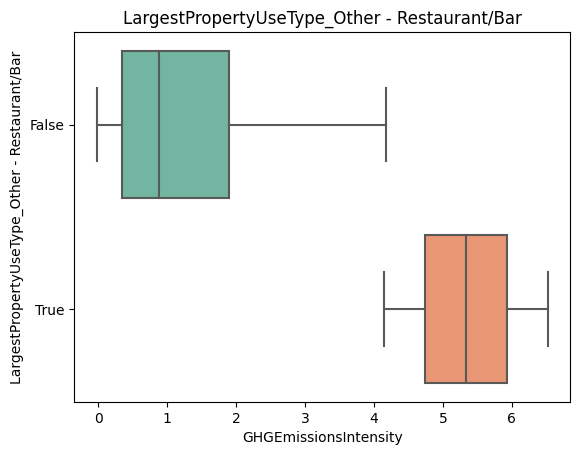


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Other - Services
LargestPropertyUseType_Other - Services
False    1618
True        5
Name: count, dtype: int64


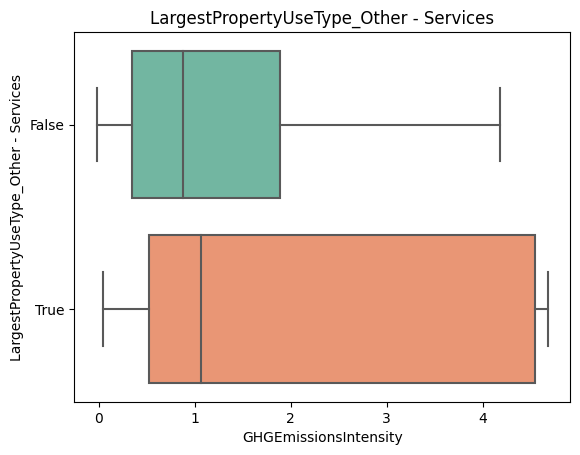


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Other - Utility
LargestPropertyUseType_Other - Utility
False    1621
True        2
Name: count, dtype: int64


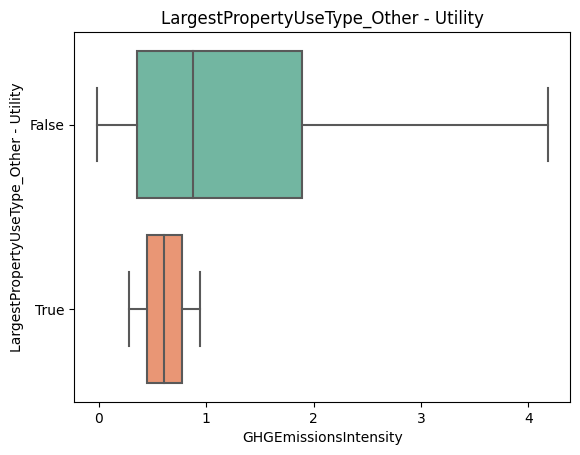


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Other/Specialty Hospital
LargestPropertyUseType_Other/Specialty Hospital
False    1619
True        4
Name: count, dtype: int64


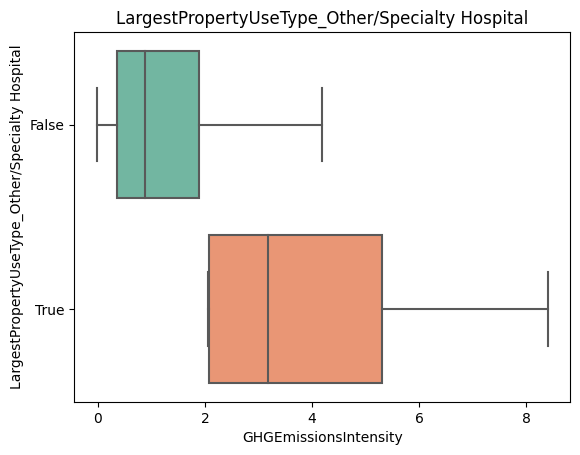


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Parking
LargestPropertyUseType_Parking
False    1593
True       30
Name: count, dtype: int64


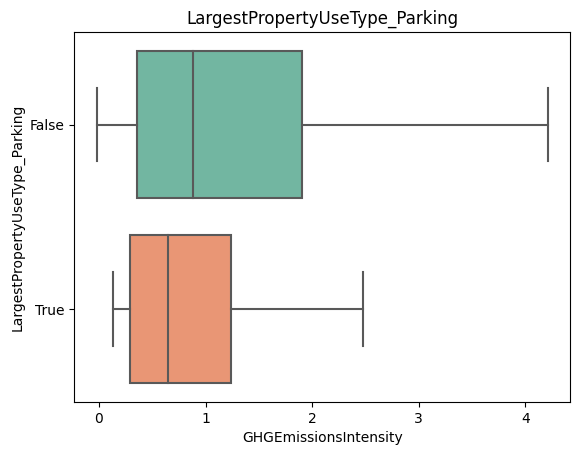


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Performing Arts
LargestPropertyUseType_Performing Arts
False    1620
True        3
Name: count, dtype: int64


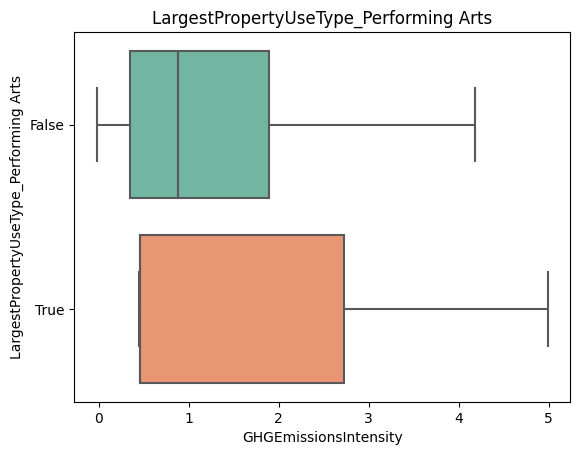


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Personal Services (Health/Beauty, Dry Cleaning, etc)
LargestPropertyUseType_Personal Services (Health/Beauty, Dry Cleaning, etc)
False    1622
True        1
Name: count, dtype: int64


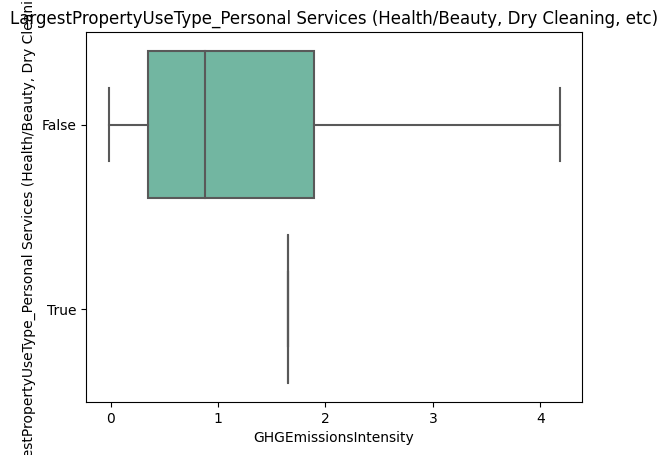


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Police Station
LargestPropertyUseType_Police Station
False    1622
True        1
Name: count, dtype: int64


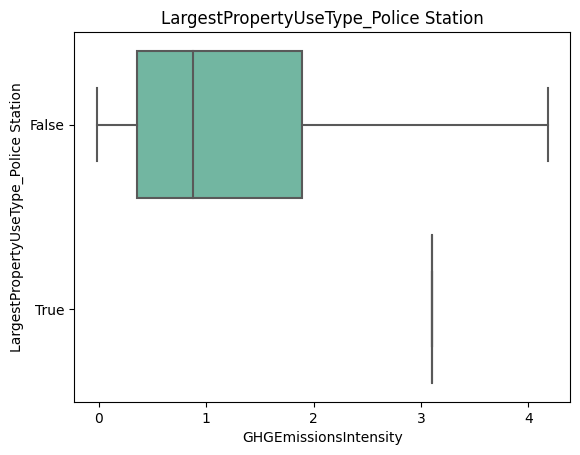


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Pre-school/Daycare
LargestPropertyUseType_Pre-school/Daycare
False    1621
True        2
Name: count, dtype: int64


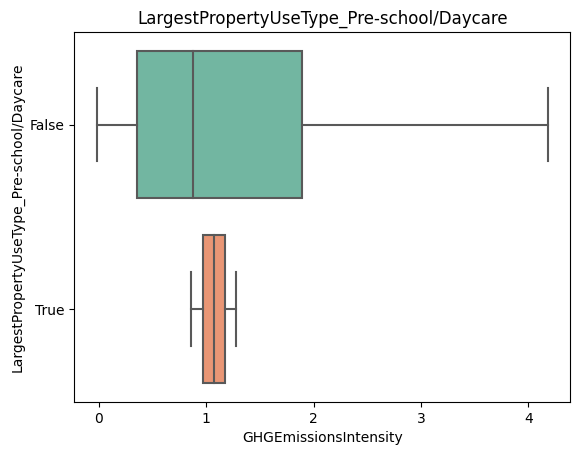


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Prison/Incarceration
LargestPropertyUseType_Prison/Incarceration
False    1620
True        3
Name: count, dtype: int64


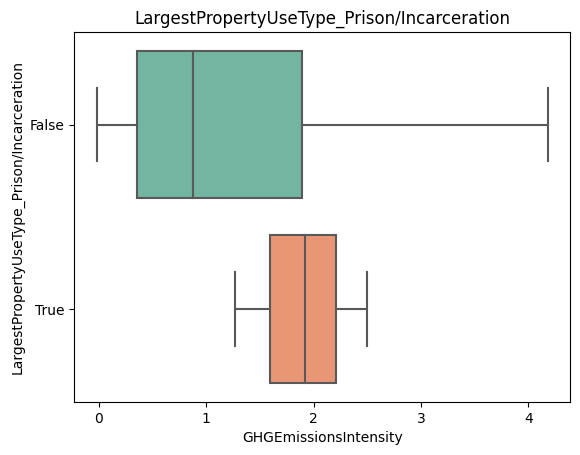


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Refrigerated Warehouse
LargestPropertyUseType_Refrigerated Warehouse
False    1611
True       12
Name: count, dtype: int64


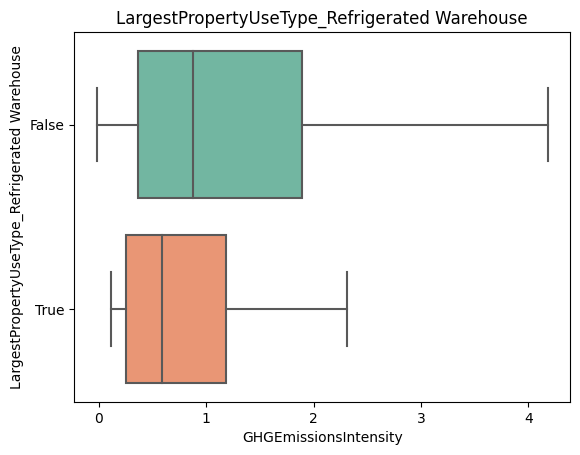


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Repair Services (Vehicle, Shoe, Locksmith, etc)
LargestPropertyUseType_Repair Services (Vehicle, Shoe, Locksmith, etc)
False    1617
True        6
Name: count, dtype: int64


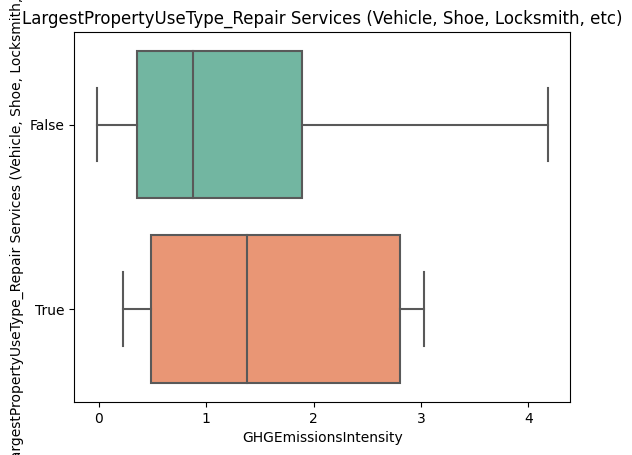


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Residence Hall/Dormitory
LargestPropertyUseType_Residence Hall/Dormitory
False    1622
True        1
Name: count, dtype: int64


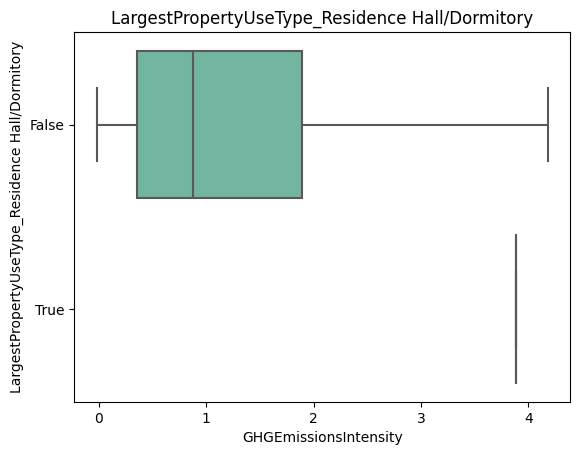


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Residential Care Facility
LargestPropertyUseType_Residential Care Facility
False    1622
True        1
Name: count, dtype: int64


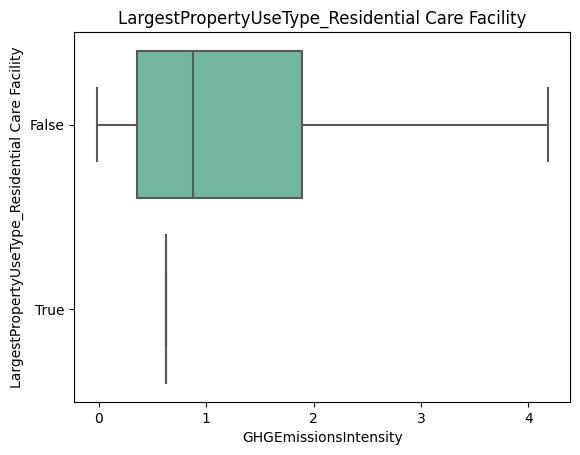


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Restaurant
LargestPropertyUseType_Restaurant
False    1610
True       13
Name: count, dtype: int64


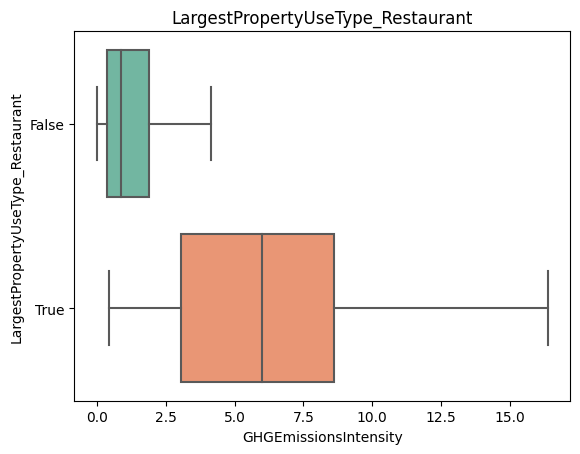


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Retail Store
LargestPropertyUseType_Retail Store
False    1524
True       99
Name: count, dtype: int64


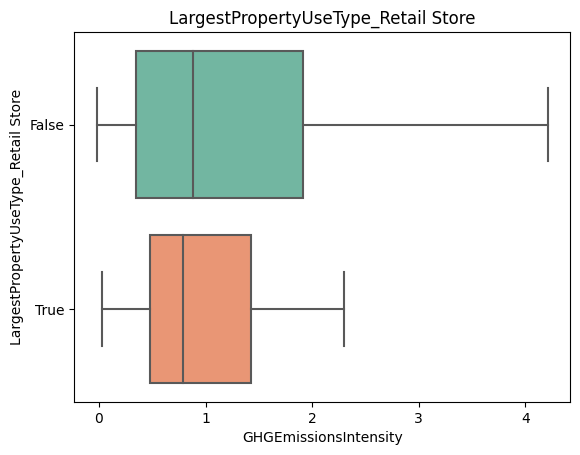


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Self-Storage Facility
LargestPropertyUseType_Self-Storage Facility
False    1595
True       28
Name: count, dtype: int64


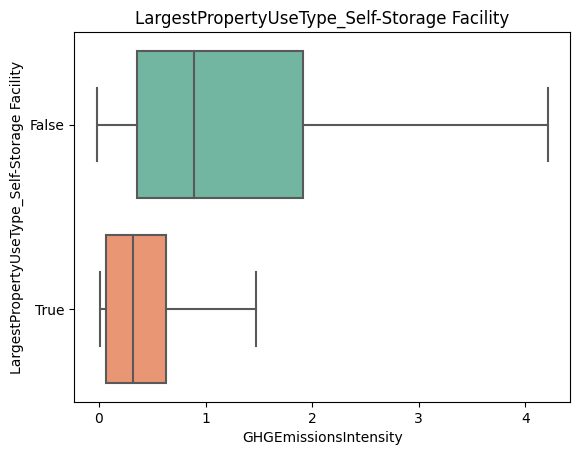


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Senior Care Community
LargestPropertyUseType_Senior Care Community
False    1603
True       20
Name: count, dtype: int64


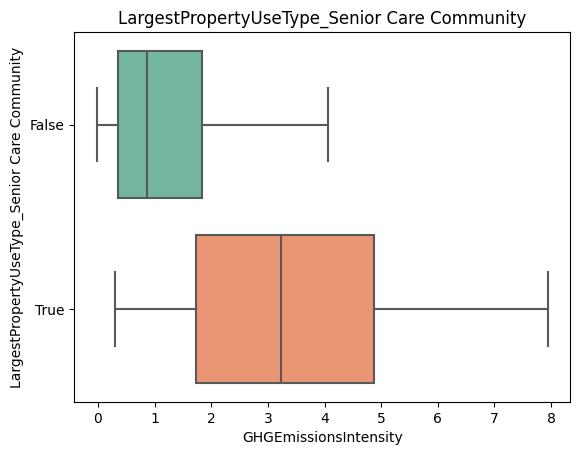


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Social/Meeting Hall
LargestPropertyUseType_Social/Meeting Hall
False    1613
True       10
Name: count, dtype: int64


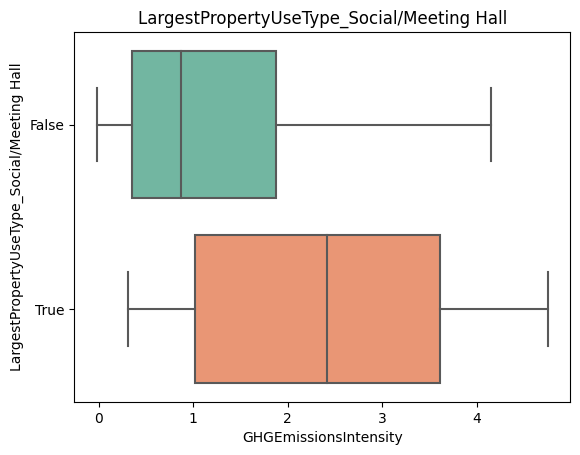


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Strip Mall
LargestPropertyUseType_Strip Mall
False    1617
True        6
Name: count, dtype: int64


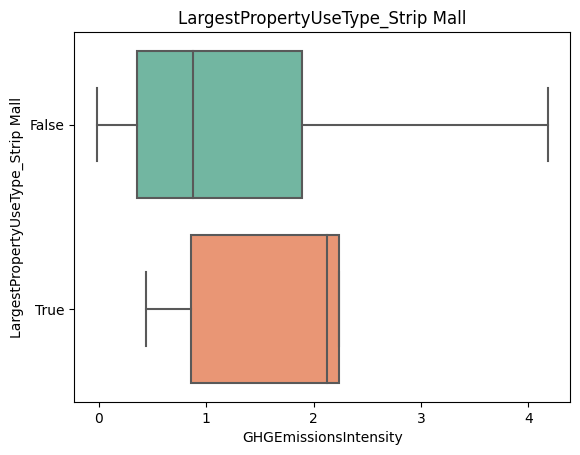


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Supermarket/Grocery Store
LargestPropertyUseType_Supermarket/Grocery Store
False    1582
True       41
Name: count, dtype: int64


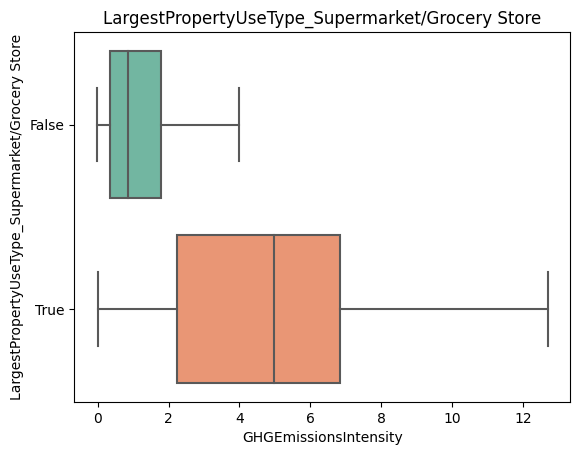


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Urgent Care/Clinic/Other Outpatient
LargestPropertyUseType_Urgent Care/Clinic/Other Outpatient
False    1619
True        4
Name: count, dtype: int64


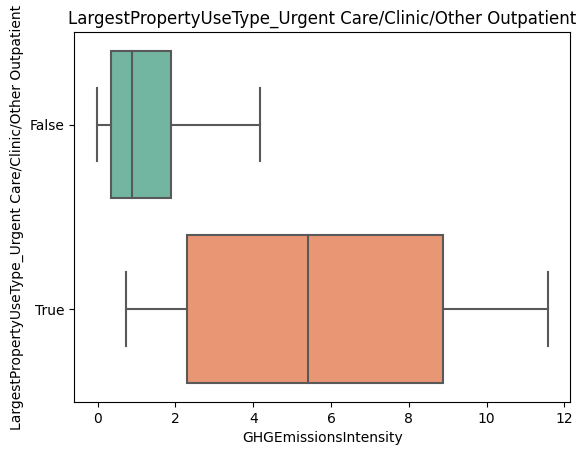


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Wholesale Club/Supercenter
LargestPropertyUseType_Wholesale Club/Supercenter
False    1622
True        1
Name: count, dtype: int64


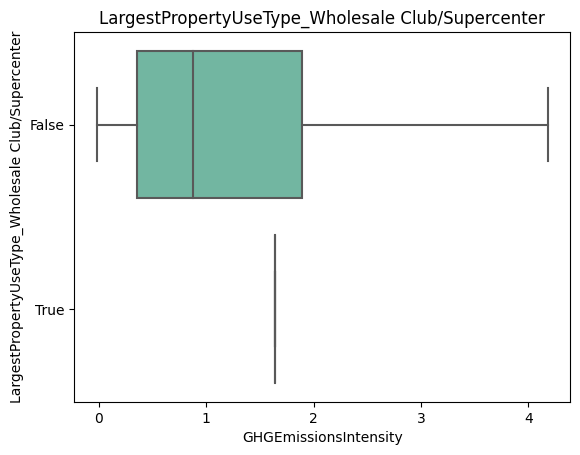


 Distribution de GHGEmissionsIntensity et  LargestPropertyUseType_Worship Facility
LargestPropertyUseType_Worship Facility
False    1552
True       71
Name: count, dtype: int64


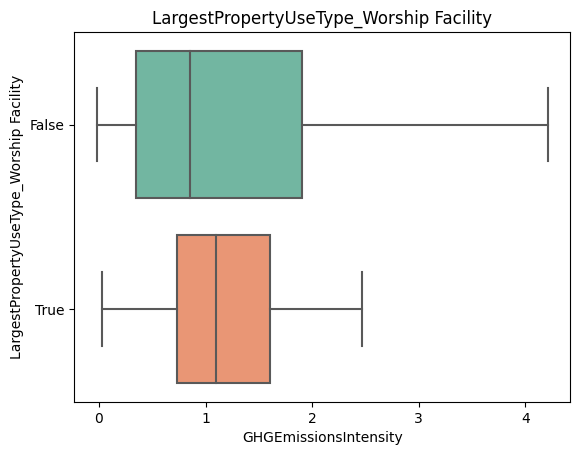

In [128]:
for col in larg_columns : 
    boxplot_test(col,'GHGEmissionsIntensity')

# Corrélations

In [262]:
# 'Latitude', 'Longitude', 
cols_num = ['p_gas','p_steam','p_elec','PropertyGFATotal', 'PropertyGFAParking','PropertyGFABuildings']
cols_categ = ['Neighborhood','BuildingType', 'PrimaryPropertyType']

ord_categ = ['NumberofBuildings','NumberofFloors','decennie','YearBuilt']

In [135]:
df.columns

Index(['BuildingType', 'PrimaryPropertyType', 'PropertyName',
       'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude',
       'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuildings',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseTypeGFA',
       'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)',
       'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)',
       'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)',
       'NaturalGas(therms)', 'NaturalGas(kBtu)', 'ComplianceStatus',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'is_laboratory',
       'is_campus', 'is_hospital', 'decennie', 'p_gas', 'p_elec', 'p_steam',
       'LargestPropertyUseType_Adult Education',
       'LargestPropertyUseType_Automobile Dealership',
       'LargestPropertyUseType_Bank Branch',
       'LargestPropertyUseType_College/University',
       'LargestPropertyUseType_Courth

In [168]:
df.loc[df['LargestPropertyUseType_Senior Care Community'] == True]

,BuildingType,PrimaryPropertyType,PropertyName,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,...,LargestPropertyUseType_Restaurant,LargestPropertyUseType_Retail Store,LargestPropertyUseType_Self-Storage Facility,LargestPropertyUseType_Senior Care Community,LargestPropertyUseType_Social/Meeting Hall,LargestPropertyUseType_Strip Mall,LargestPropertyUseType_Supermarket/Grocery Store,LargestPropertyUseType_Urgent Care/Clinic/Other Outpatient,LargestPropertyUseType_Wholesale Club/Supercenter,LargestPropertyUseType_Worship Facility
59,NonResidential,Senior Care Community,PSSA - The Mount,1,southwest,47.55837,-122.37751,1922,1.0,5,...,False,False,False,True,False,False,False,False,False,False
60,NonResidential,Senior Care Community,Foss Home and Village,5,northwest,47.72426,-122.35599,1970,1.0,2,...,False,False,False,True,False,False,False,False,False,False
171,NonResidential,Senior Care Community,ID Village Square 1,2,downtown,47.59626,-122.32180,1999,1.0,5,...,False,False,False,True,False,False,False,False,False,False
888,NonResidential,Senior Care Community,Cabrini Senior Housing,3,east,47.60897,-122.32507,2006,1.0,6,...,False,False,False,True,False,False,False,False,False,False
966,NonResidential,Senior Care Community,Washington Care Center,2,southeast,47.57188,-122.29531,1981,1.0,3,...,False,False,False,True,False,False,False,False,False,False
1109,NonResidential,Senior Care Community,Ballard Center,6,ballard,47.69875,-122.36725,1966,1.0,2,...,False,False,False,True,False,False,False,False,False,False
1123,NonResidential,Senior Care Community,Kin On Health Care Center,2,southeast,47.55387,-122.27875,1966,1.0,2,...,False,False,False,True,False,False,False,False,False,False
1208,NonResidential,Senior Care Community,Queen Anne Healthcare,7,magnolia / queen anne,47.64410,-122.34795,1970,1.0,2,...,False,False,False,True,False,False,False,False,False,False
1418,NonResidential,Senior Care Community,Mirabella Seattle,7,lake union,47.61935,-122.33389,2006,1.0,14,...,False,False,False,True,False,False,False,False,False,False
1456,NonResidential,Senior Care Community,HEALTH AND REHAB OF NORTH SEATTLE,5,northwest,47.72618,-122.35642,1954,1.0,2,...,False,False,False,True,False,False,False,False,False,False


In [169]:
df.loc[df['LargestPropertyUseType_Supermarket/Grocery Store'] == True]

,BuildingType,PrimaryPropertyType,PropertyName,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,...,LargestPropertyUseType_Restaurant,LargestPropertyUseType_Retail Store,LargestPropertyUseType_Self-Storage Facility,LargestPropertyUseType_Senior Care Community,LargestPropertyUseType_Social/Meeting Hall,LargestPropertyUseType_Strip Mall,LargestPropertyUseType_Supermarket/Grocery Store,LargestPropertyUseType_Urgent Care/Clinic/Other Outpatient,LargestPropertyUseType_Wholesale Club/Supercenter,LargestPropertyUseType_Worship Facility
254,NonResidential,Supermarket / Grocery Store,70500872 -- Holman Road,6,northwest,47.70190,-122.36374,1956,1.0,1,...,False,False,False,False,False,False,True,False,False,False
356,NonResidential,Supermarket / Grocery Store,70100179-Lake City,5,north,47.72370,-122.29232,1995,1.0,2,...,False,False,False,False,False,False,True,False,False,False
357,NonResidential,Supermarket / Grocery Store,RESTAURANT DEPOT SEATTLE (ID503),2,greater duwamish,47.56895,-122.33775,2008,1.0,1,...,False,False,False,False,False,False,True,False,False,False
367,NonResidential,Supermarket / Grocery Store,00410-Hwy 99 & 130th,5,northwest,47.72350,-122.34458,1997,1.0,1,...,False,False,False,False,False,False,True,False,False,False
401,NonResidential,Supermarket / Grocery Store,Safeway 1845 - Greenwood Ave,5,northwest,47.69267,-122.35506,2003,1.0,1,...,False,False,False,False,False,False,True,False,False,False
402,NonResidential,Supermarket / Grocery Store,70500858 -- North Seattle,5,north,47.73315,-122.31050,1980,1.0,1,...,False,False,False,False,False,False,True,False,False,False
447,NonResidential,Supermarket / Grocery Store,Safeway 1965 - Rainier Ave,2,southeast,47.52095,-122.26825,2002,1.0,1,...,False,False,False,False,False,False,True,False,False,False
513,NonResidential,Supermarket / Grocery Store,IUC- Whole Foods Interbay,7,magnolia / queen anne,47.63718,-122.37734,2008,1.0,1,...,False,False,False,False,False,False,True,False,False,False
542,NonResidential,Supermarket / Grocery Store,70100122-Greenwood,6,northwest,47.69197,-122.35877,1970,1.0,1,...,False,False,False,False,False,False,True,False,False,False
600,NonResidential,Supermarket / Grocery Store,70500849 -- Rainier Valley,2,greater duwamish,47.57903,-122.29982,1963,1.0,1,...,False,False,False,False,False,False,True,False,False,False


In [ ]:
df.index

In [170]:
list = ['LargestPropertyUseType_Supermarket/Grocery Store','LargestPropertyUseType_Restaurant','LargestPropertyUseType_Senior Care Community','LargestPropertyUseType_Other - Recreation','LargestPropertyUseType_Data Center','LargestPropertyUseType_Hotel','LargestPropertyUseType_Social/Meeting Hall','LargestPropertyUseType_Fitness Center/Health Club/Gym']

### Anova

['Neighborhood','BuildingType', 'PrimaryPropertyType','YearBuilt', 'NumberofBuildings',
       'NumberofFloors',
       'PropertyGFABuilding(s)',
       'ComplianceStatus',
       'Outlier']

In [198]:
anova_df = df.copy()
anova_df = pd.get_dummies(anova_df, columns=['Neighborhood','BuildingType', 'PrimaryPropertyType'])

In [194]:
def shaping_df(x):
    # remplace esapce par tiret bas
    y = x.replace(" ","_")
    y = y.replace("/","")
    y = y.replace("-","_")
    return y
anova_df.PrimaryPropertyType = anova_df.PrimaryPropertyType.map(shaping_df)
anova_df.BuildingType = anova_df.BuildingType.map(shaping_df)
anova_df.Neighborhood = anova_df.Neighborhood.map(shaping_df)

In [92]:
anova_df.columns

Index(['PropertyName', 'CouncilDistrictCode', 'Latitude', 'Longitude',
       'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuildings',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'ComplianceStatus', 'TotalGHGEmissions', 'GHGEmissionsIntensity',
       'is_laboratory', 'is_campus', 'is_hospital', 'decennie', 'p_gas',
       'p_elec', 'p_steam', 'Neighborhood_ballard', 'Neighborhood_central',
       'Neighborhood_delridge', 'Neighborhood_downtown', 'Neighborhood_east',
       'Neighborhood_greater_duwamish', 'Neighborhood_lake_union',
       'Neighborhood_magnolia__queen_anne', 'Neighborhood_north',
       '

In [93]:
str = """'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'is_laboratory', 'is_hospital',
       'is_campus', 'Neighborhood_ballard', 'Neighborhood_central',
       'Neighborhood_delridge', 'Neighborhood_downtown', 'Neighborhood_east',
       'Neighborhood_greater_duwamish', 'Neighborhood_lake_union',
       'Neighborhood_magnolia__queen_anne', 'Neighborhood_north',
       'Neighborhood_northeast', 'Neighborhood_northwest',
       'Neighborhood_southeast', 'Neighborhood_southwest',
       'BuildingType_NonResidential',
       'BuildingType_Nonresidential_COS', 'BuildingType_Nonresidential_WA',
       'BuildingType_SPS_District_K_12',
       'PrimaryPropertyType_Distribution_Center',
       'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_K_12_School', 
       'PrimaryPropertyType_Large_Office',
       'PrimaryPropertyType_Medical_Office',
       'PrimaryPropertyType_Mixed_Use_Property', 'PrimaryPropertyType_Office',
       'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Refrigerated_Warehouse',
       'PrimaryPropertyType_Restaurant', 'PrimaryPropertyType_Retail_Store',
       'PrimaryPropertyType_Self_Storage_Facility',
       'PrimaryPropertyType_Senior_Care_Community',
       'PrimaryPropertyType_Small__and_Mid_Sized_Office',
       'PrimaryPropertyType_Supermarket__Grocery_Store',
       'PrimaryPropertyType_Warehouse',
       'PrimaryPropertyType_Worship_Facility','p_gas','p_steam','p_elec','PropertyGFATotal', 'PropertyGFAParking','PropertyGFABuildings'"""

In [187]:
Lstr2 = ['YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'is_laboratory', 'is_hospital',
       'is_campus','p_gas','p_steam','p_elec','PropertyGFATotal', 'PropertyGFAParking','PropertyGFABuildings','LargestPropertyUseType_Supermarket/Grocery Store','PrimaryPropertyType_Restaurant','LargestPropertyUseType_Senior Care Community','LargestPropertyUseType_Other - Recreation','LargestPropertyUseType_Data Center','LargestPropertyUseType_Hotel','LargestPropertyUseType_Social/Meeting Hall','LargestPropertyUseType_Fitness Center/Health Club/Gym']

In [199]:
def format_col(str):
    str = str.replace("""'""","")
    str = str.replace("""\n""","")
    str = str.replace("""/""","")
    str = str.replace(""" ""","_")
    str = str.replace("-","_")
    return str

In [200]:
for col in anova_df.columns:
    col_formatted = format_col(col)
    anova_df.rename(columns={col:col_formatted},inplace=True)
anova_df.columns

Index(['PropertyName', 'CouncilDistrictCode', 'Latitude', 'Longitude',
       'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuildings',
       ...
       'PrimaryPropertyType_Refrigerated_Warehouse',
       'PrimaryPropertyType_Restaurant', 'PrimaryPropertyType_Retail_Store',
       'PrimaryPropertyType_Self_Storage_Facility',
       'PrimaryPropertyType_Senior_Care_Community',
       'PrimaryPropertyType_Small__and_Mid_Sized_Office',
       'PrimaryPropertyType_Supermarket__Grocery_Store',
       'PrimaryPropertyType_University', 'PrimaryPropertyType_Warehouse',
       'PrimaryPropertyType_Worship_Facility'],
      dtype='object', length=126)

In [189]:
str2=""
for col in Lstr2 : 
    str2+= (" + " + format_col(col))
str2

' + YearBuilt + NumberofBuildings + NumberofFloors + is_laboratory + is_hospital + is_campus + p_gas + p_steam + p_elec + PropertyGFATotal + PropertyGFAParking + PropertyGFABuildings + LargestPropertyUseType_SupermarketGrocery_Store + PrimaryPropertyType_Restaurant + LargestPropertyUseType_Senior_Care_Community + LargestPropertyUseType_Other_-_Recreation + LargestPropertyUseType_Data_Center + LargestPropertyUseType_Hotel + LargestPropertyUseType_SocialMeeting_Hall + LargestPropertyUseType_Fitness_CenterHealth_ClubGym'

In [218]:
reg2 = ols('TotalGHGEmissions ~  NumberofBuildings + NumberofFloors + is_laboratory + is_hospital + p_gas + p_steam + PropertyGFABuildings + LargestPropertyUseType_SupermarketGrocery_Store + LargestPropertyUseType_Senior_Care_Community +LargestPropertyUseType_Data_Center + LargestPropertyUseType_Hotel -1',data = anova_df).fit()
print(reg2.summary())

                            OLS Regression Results                            
Dep. Variable:      TotalGHGEmissions   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     348.8
Date:                Wed, 02 Aug 2023   Prob (F-statistic):               0.00
Time:                        11:31:10   Log-Likelihood:                -11635.
No. Observations:                1623   AIC:                         2.329e+04
Df Residuals:                    1611   BIC:                         2.336e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

In [294]:
#  BuildingType +  PrimaryPropertyType 
reg = ols('TotalGHGEmissions ~  NumberofFloors + NumberofBuildings +PrimaryPropertyType_Large_Office +PrimaryPropertyType_Supermarket__Grocery_Store+ PropertyGFABuildings+ PrimaryPropertyType_Hotel +is_laboratory+ is_hospital  - 1', data = anova_df).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:      TotalGHGEmissions   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     409.4
Date:                Wed, 02 Aug 2023   Prob (F-statistic):               0.00
Time:                        12:12:02   Log-Likelihood:                -11725.
No. Observations:                1623   AIC:                         2.347e+04
Df Residuals:                    1614   BIC:                         2.352e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

## Pearson

# Feature Engineering

# TotalGHGEmissions : Prediction

In [291]:
features = ['NumberofBuildings' , 'NumberofFloors' , 'is_laboratory' , 'is_hospital' , 'p_gas' , 'p_steam' , 'PropertyGFABuildings' , 'LargestPropertyUseType_SupermarketGrocery_Store' , 'LargestPropertyUseType_Senior_Care_Community' ,'LargestPropertyUseType_Data_Center' , 'LargestPropertyUseType_Hotel']
# a corriger
X = anova_df[features]
y = anova_df['TotalGHGEmissions']

In [292]:
rf = RandomForestRegressor()
param_rf = {'n_estimators':[i for i in range(1,20,1)],
           'max_depth':[i for i in range(1,10,1)]}
regr = GridSearchCV(rf,param_grid=param_rf,scoring='r2',cv=5,refit=True)
regr.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19]},
             scoring='r2')

In [286]:
regr.score(X_train,y_train)

0.8191264306607651

In [287]:
params = regr.best_params_

In [288]:
final_rf = RandomForestRegressor(n_estimators = params['n_estimators'],max_depth=params['max_depth'])
final_rf.fit(X_train,y_train)
metrics.r2_score(y_test,final_rf.predict(X_test))

0.35635058378986717